# <h1 align="center"> Exercise: Feed-forward NNs for Structured Data Classification </h1>


# Day 1

## Introduction

The idea of this exercise is to learn how to do structured data classification using neural networks, starting from a raw
CSV file. Our data includes both numerical and categorical features.

### The dataset

[Our dataset](https://archive.ics.uci.edu/ml/datasets/heart+Disease) is provided by the
Cleveland Clinic Foundation for Heart Disease.
It's a CSV file with 303 rows. Each row contains information about a patient (a
**sample**), and each column describes an attribute of the patient (a **feature**). We
use the features to predict whether a patient has a heart disease (**binary
classification**).

Here's the description of each feature:

Column| Description| Feature Type
------------|--------------------|----------------------
Age | Age in years | Numerical
Sex | (1 = male; 0 = female) | Categorical
CP | Chest pain type (0, 1, 2, 3, 4) | Categorical
Trestbpd | Resting blood pressure (in mm Hg on admission) | Numerical
Chol | Serum cholesterol in mg/dl | Numerical
FBS | fasting blood sugar in 120 mg/dl (1 = true; 0 = false) | Categorical
RestECG | Resting electrocardiogram results (0, 1, 2) | Categorical
Thalach | Maximum heart rate achieved | Numerical
Exang | Exercise induced angina (1 = yes; 0 = no) | Categorical
Oldpeak | ST depression induced by exercise relative to rest | Numerical
Slope | Slope of the peak exercise ST segment | Numerical
CA | Number of major vessels (0-3) colored by fluoroscopy | Both numerical & categorical
Thal | 3 = normal; 6 = fixed defect; 7 = reversible defect | Categorical
Target | Diagnosis of heart disease (1 = true; 0 = false) | Target

## Key Objectives - Day 1


1. Your key task is to perform a binary classification problem to predict heart disease based on the given data by splitting it into train-valid-test datasets

2. You will build a variety of dense neural network models starting from simple 1-layer NNs to 2 and 3 layer dense NNs

3. You will also plot learning curves to visualize training performance over epochs

4. You will also evaluate the performance of the models on the test dataset

5. You will also build a model using class weights to tackle class imbalance



## Load Dependencies

In [2]:
import tensorflow as tf
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.impute import KNNImputer


# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"


# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

# Common imports
import numpy as np
import os
import math

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

In [3]:
tf.random.set_seed(3) # reproducibility

## Load the dataset

Let's download the data and load it into a Pandas dataframe:

In [115]:
file_url = "http://storage.googleapis.com/download.tensorflow.org/data/heart.csv"
df = pd.read_csv(file_url)

The dataset includes 303 samples with 14 columns per sample (13 features, plus the target
label):

In [5]:
df.shape

(303, 14)

Here's a preview of a few samples:

In [6]:
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,1,145,233,1,2,150,0,2.3,3,0,fixed,0
1,67,1,4,160,286,0,2,108,1,1.5,2,3,normal,1
2,67,1,4,120,229,0,2,129,1,2.6,2,2,reversible,0
3,37,1,3,130,250,0,0,187,0,3.5,3,0,normal,0
4,41,0,2,130,204,0,2,172,0,1.4,1,0,normal,0


The last column, "target", indicates whether the patient has a heart disease (1) or not
(0).

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trestbps  303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalach   303 non-null    int64  
 8   exang     303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    int64  
 11  ca        303 non-null    int64  
 12  thal      303 non-null    object 
 13  target    303 non-null    int64  
dtypes: float64(1), int64(12), object(1)
memory usage: 33.3+ KB


## Check the distribution of the target column

In [8]:
df.target.value_counts()   # imbalance

target
0    220
1     83
Name: count, dtype: int64

In [9]:
df.thal.value_counts()

thal
normal        168
reversible    115
fixed          18
1               1
2               1
Name: count, dtype: int64

In [117]:
df = df[~df.thal.isin(['1','2'])]

# Task 1: Split Dataset into Train, Validation and Test Datasets

Use stratified sampling to ensure similar `target` class distribution in the dataset splits when using `train_test_split()`

Use a split of 60:20:20 for train-valid-test splits
For reproducibility set the `random_state` to `42`

In [118]:
from sklearn.model_selection import train_test_split

# First split: 60% train and 40% test + valid
X_train, X_test_valid, y_train, y_test_valid = train_test_split(
    df.drop(columns=["target"]),  # Features
    df["target"],  # Target
    train_size=0.6,  # 40% for testing
    random_state=42,
    stratify=df["target"] # 分层：该stratify参数确保目标变量的分布在训练和测试集中都保持不变，这对于平衡分类很重要。
)

# Second split: 50% test and 50% valid
X_test, X_valid, y_test, y_valid = train_test_split(
    X_test_valid,
    y_test_valid,
    test_size=0.5,
    random_state=42,
    stratify=y_test_valid  # Stratification for validation
)

In [119]:
X_train.shape, X_valid.shape, X_test.shape

((180, 13), (61, 13), (60, 13))

# Task 2: Data Pre-processing

Recall the data pre-processing you had learnt during the ML week! Perform the following tasks to have clean and pre-processed datasets for your training, validation and test datasets.

Key Steps:

1. One-hot encode categorical data
2. Standard Scaling numerical data
3. Combine categorical and numeric data together into a single dataframe \ numpy array

Hints: Leverage code from [here](https://colab.research.google.com/drive/1ISCLIEkrLhtNo0r-hAmA6fYA6nkB1o59) [pre-processing parts only]

In [120]:
# categorical_features = X_train.select_dtypes(include=['object']).columns.tolist()
# numeric_features = X_train.select_dtypes(exclude=['object']).columns.tolist()

categorical_features = ['sex', 'cp', 'fbs', 'restecg', 'exang', 'ca', 'thal']
numeric_features = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak', 'slope']

In [121]:
# categorical_transformer
categorical_transformer = Pipeline(steps=[
                                          ("onehot", OneHotEncoder(sparse_output=False,
                                                                   handle_unknown="ignore").set_output(transform="pandas"))
                                          ])

# numeric_transformer
numeric_transformer = Pipeline(steps=[
                                      ("scaler", StandardScaler().set_output(transform="pandas"))
                                      ])

# preprocessor
preprocessor = ColumnTransformer(transformers=[
                                               ("num", numeric_transformer, numeric_features),
                                               ("cat", categorical_transformer, categorical_features)
                                               ]).set_output(transform="pandas")
preprocessor

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('scaler', StandardScaler())]),
                                 ['age', 'trestbps', 'chol', 'thalach',
                                  'oldpeak', 'slope']),
                                ('cat',
                                 Pipeline(steps=[('onehot',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False))]),
                                 ['sex', 'cp', 'fbs', 'restecg', 'exang', 'ca',
                                  'thal'])])

In [122]:
X_train_processed = preprocessor.fit_transform(X_train)
X_valid_processed = preprocessor.transform(X_valid)
X_test_processed = preprocessor.transform(X_test)

# 因此，X_train_processed 包含了基于训练集数据的参数进行的转换，而 X_valid_processed 和 X_test_processed 则是应用训练集学到的参数来进行转换。

In [82]:
X_train.shape

(180, 13)

In [83]:
X_train_processed.shape

(180, 27)

In [123]:
columns = list(X_test_processed.columns)

In [125]:
X_train = pd.DataFrame(X_train_processed, columns=columns)
X_valid = pd.DataFrame(X_valid_processed, columns=columns)
X_test = pd.DataFrame(X_test_processed, columns=columns)

In [20]:
X_train.head()

,num__age,num__trestbps,num__chol,num__thalach,num__oldpeak,num__slope,cat__sex_0,cat__sex_1,cat__cp_0,cat__cp_1,...,cat__restecg_2,cat__exang_0,cat__exang_1,cat__ca_0,cat__ca_1,cat__ca_2,cat__ca_3,cat__thal_fixed,cat__thal_normal,cat__thal_reversible
286,-1.083146,-0.903756,0.253956,1.585937,-0.914960,-0.950923,0.0,1.0,0.0,0.0,...,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
145,-0.522576,-0.628127,-0.050537,0.579070,-0.026039,-0.950923,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
258,-0.410462,-1.179385,-1.363665,-1.128226,-0.430094,-0.950923,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
148,1.047020,2.679417,1.490960,0.228855,-0.914960,-0.950923,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
70,0.934906,-0.076870,1.586114,-0.734234,0.539638,-0.950923,0.0,1.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0


In [21]:
X_train.shape

(180, 27)

In [22]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 180 entries, 286 to 165
Data columns (total 27 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   num__age              180 non-null    float64
 1   num__trestbps         180 non-null    float64
 2   num__chol             180 non-null    float64
 3   num__thalach          180 non-null    float64
 4   num__oldpeak          180 non-null    float64
 5   num__slope            180 non-null    float64
 6   cat__sex_0            180 non-null    float64
 7   cat__sex_1            180 non-null    float64
 8   cat__cp_0             180 non-null    float64
 9   cat__cp_1             180 non-null    float64
 10  cat__cp_2             180 non-null    float64
 11  cat__cp_3             180 non-null    float64
 12  cat__cp_4             180 non-null    float64
 13  cat__fbs_0            180 non-null    float64
 14  cat__fbs_1            180 non-null    float64
 15  cat__restecg_0        180 

# Task 3: Training simple 1-layer Neural Networks

Run the following experiments separately to train 1-layer neural networks, evaluate the performance by looking at learning curve plots and finally check the performance of each of the following models on the test dataset.

Key workflow:

- Build model using architecture specification based on experiment
- Plot learning curves from model training to visualize performance over epochs on training and validation data
- Use trained model to predict and evaluate performance on test data
- Build separate models for each experiment


### Hint: Utility function for plotting learning curves

You can use the following function to plot the learning curves after training.

Remember to do the following during training:

```
history = model.fit(.......)

# to plot the curves
plot_metrics(history)
```

In [23]:
import matplotlib.pyplot as plt


def plot_metrics(history):

  keys = history.history.keys()
  metrics = ['loss', 'accuracy', 'precision', 'recall']
  plt.figure(figsize=(12, 10))
  for n, metric in enumerate(metrics):
    name = metric.capitalize()
    metric_name = [item for item in keys if metric in item and 'val_'+metric not in item][0]
    val_metric_name = [item for item in keys if 'val_'+metric in item][0]

    plt.subplot(2,2,n+1)
    plt.plot(history.epoch, history.history[metric_name], color='b', label='Train')
    plt.plot(history.epoch, history.history[val_metric_name], color='r',
             linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    plt.legend()

## Complete Task 3 Below

**补充：输出层的神经元数量应与类别数一致。**
- 二分类问题：使用 Dense(1)，配合 sigmoid 激活函数。- 输出一个值，表示某个样本属于正类的概率（0 到 1 之间的数值）。
- 多分类问题（例如三分类）：使用 Dense(3)（对于 3 个类别），配合 softmax 激活函数。输出三个值，这三个值代表样本属于每个类别的概率，这些概率的和为 1。

## Experiment 1 - Basic NN:
- 1-Dense Hidden Layer, 32 units, `relu` activation function
- 1-Dense Output Layer, 1 unit, `sigmoid` activation function
- learning rate: 0.001
- optimizer is SGD
- metrics: 'accuracy', [precision](https://www.tensorflow.org/api_docs/python/tf/keras/metrics/Precision), [recall](https://www.tensorflow.org/api_docs/python/tf/keras/metrics/Recall)
- loss: [binary crossentropy](https://www.tensorflow.org/api_docs/python/tf/keras/losses/BinaryCrossentropy)
- epochs: 500
- batch size: 32
- use training data and validation data in `fit()` function
- use `predict()` on test data and show confusion matrix and classification reports


In [24]:
X_train.shape

(180, 27)

In [25]:
X_train.shape[1:]

(27,)

### Define Model

In [26]:
model1 = tf.keras.models.Sequential(
    [
        tf.keras.layers.Dense(32, activation="relu", input_shape=X_train.shape[1:]),  # 8个特征 + 10种权重组合 - 生成换成10个神经元
        tf.keras.layers.Dense(1, activation="sigmoid")
    ]
)

/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [27]:
#Its layers are accessible via the layers attribute:
model1.layers

[<Dense name=dense, built=True>, <Dense name=dense_1, built=True>]

In [28]:
model1.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 32)             │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 929 (3.63 KB)

 Trainable params: 929 (3.63 KB)

 Non-trainable params: 0 (0.00 B)

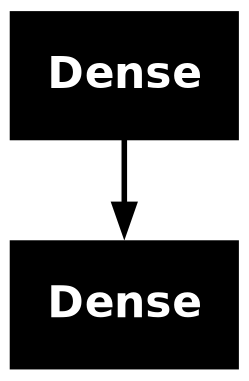

In [29]:
tf.keras.utils.plot_model(model1)

### Compile Model

In [30]:
sgd_optimizer = tf.keras.optimizers.SGD(learning_rate=0.001)

model1.compile(
    loss='binary_crossentropy',
    optimizer=sgd_optimizer,
    metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)

### Train Model

In [31]:
history1 = model1.fit(
    X_train,
    y_train,
    batch_size=32,
    epochs=500,
    validation_data=(X_valid, y_valid)
)

Epoch 1/500


I0000 00:00:1727842459.579890      99 service.cc:145] XLA service 0x77fad80014c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1727842459.579954      99 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


1/6 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step - accuracy: 0.7500 - loss: 0.5977 - precision: 0.0000e+00 - recall: 0.0000e+00

I0000 00:00:1727842460.374622      99 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 228ms/step - accuracy: 0.7024 - loss: 0.6196 - precision: 0.3057 - recall: 0.1243 - val_accuracy: 0.7213 - val_loss: 0.6318 - val_precision: 0.5000 - val_recall: 0.2353
Epoch 2/500
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7024 - loss: 0.6181 - precision: 0.3057 - recall: 0.1243 - val_accuracy: 0.7377 - val_loss: 0.6305 - val_precision: 0.5714 - val_recall: 0.2353
Epoch 3/500
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7024 - loss: 0.6167 - precision: 0.3057 - recall: 0.1243 - val_accuracy: 0.7377 - val_loss: 0.6293 - val_precision: 0.5714 - val_recall: 0.2353
Epoch 4/500
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7060 - loss: 0.6153 - precision: 0.3184 - recall: 0.1243 - val_accuracy: 0.7377 - val_loss: 0.6280 - val_precision: 0.5714 - val_recall: 0.2353
Epoch 5/500
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7060 - loss: 0.6139 - precision: 0.3184 - recall: 0.1243 - val_accuracy: 0.7541 - val_loss: 0.6268 - val_precision: 0.6

### Predict with Model

In [32]:
# predict on unseen X_test
model1.predict(X_test)

# 预测并转换为类别标签
y_pred = (model1.predict(X_test) >= 0.5).astype(int)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


In [33]:
# Calculating the f1_score
from sklearn.metrics import confusion_matrix, classification_report, f1_score

f1_dt_bs = round(f1_score(y_test, y_pred, average='weighted') * 100, 2)
print('F1 Score of the model:', f1_dt_bs)
print('-' * 60)
print(classification_report(y_test, y_pred))
f1_dt_bs_class_0 = round(classification_report(y_test, y_pred, output_dict=True)['0']['f1-score'],2)
f1_dt_bs_class_1 = round(classification_report(y_test, y_pred, output_dict=True)['1']['f1-score'],2)
print('-' * 60)
pd.DataFrame(confusion_matrix(y_test, y_pred),
             columns=['No', 'Yes'], index=['No', 'Yes'])

F1 Score of the model: 71.07
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.77      0.98      0.86        44
           1       0.75      0.19      0.30        16

    accuracy                           0.77        60
   macro avg       0.76      0.58      0.58        60
weighted avg       0.76      0.77      0.71        60

------------------------------------------------------------


,No,Yes
No,43,1
Yes,13,3


In [34]:
# Validation on the test data set
test_result1 = model1.evaluate(X_test, y_test, verbose=0)         # verbose=0：不会显示任何输出。评估过程将默默运行。

# Print the results
print("Test Loss: {:.4f}".format(test_result1[0]))       # Loss (binary crossentropy)
print("Test Accuracy: {:.4f}".format(test_result1[1]))   # Accuracy
print("Test Precision: {:.4f}".format(test_result1[2]))  # Precision
print("Test Recall: {:.4f}".format(test_result1[3]))     # Recall


Test Loss: 0.3824
Test Accuracy: 0.7667
Test Precision: 0.7500
Test Recall: 0.1875


### Plotting learning Curves

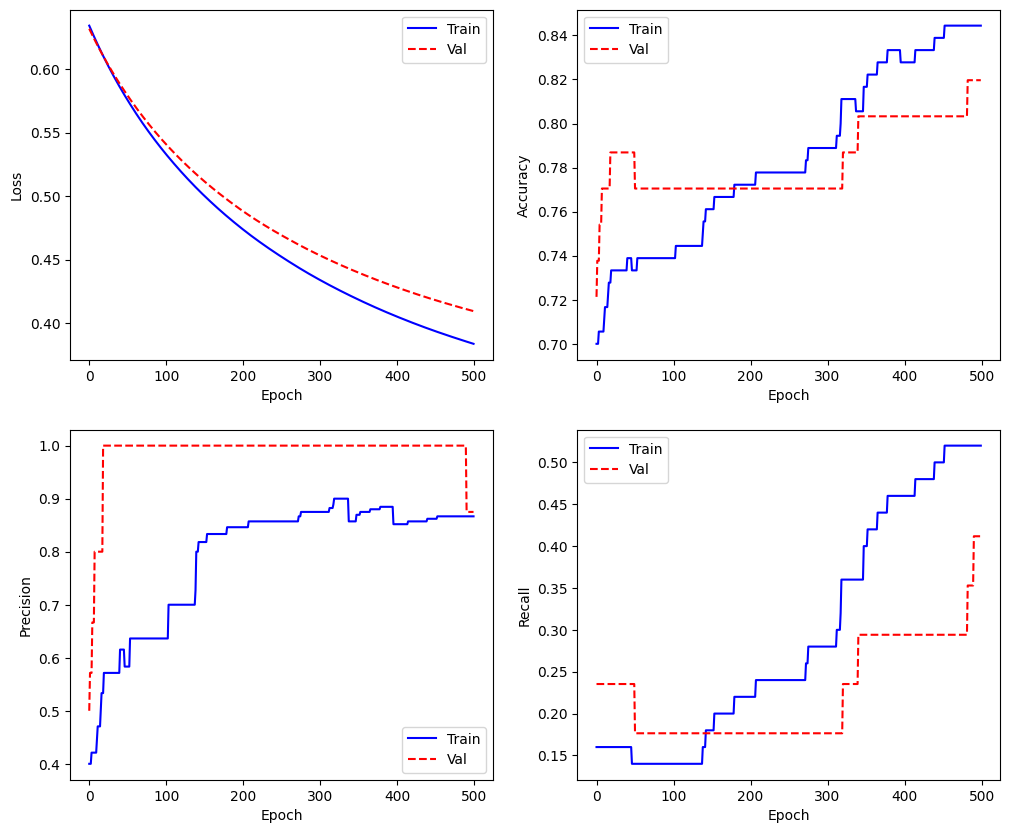

In [35]:
plot_metrics(history1)

你提到的是二分类问题，但在 `model.predict(X_test)` 的输出中，你看到了连续的数值，而不是你期望的二分类结果（如0或1）。这是因为你的模型输出的是**概率值**，而不是直接的类别标签。

**原因：**
- 你在模型的输出层使用了 `sigmoid` 激活函数（假设你的模型是用来进行二分类的）。`sigmoid` 的输出是一个介于 0 和 1 之间的概率值，表示该样本属于某一类别的概率。
- 比如，`model.predict(X_test)` 的输出可能是 `0.6`，它表示模型预测该样本属于类别 1 的概率是 60%，而属于类别 0 的概率是 40%。

**如何将概率转换为类别标签：**
如果你希望得到实际的二分类标签（0 或 1），你需要将这些概率值转换为二进制类别。通常的做法是使用一个**阈值**（通常是 0.5），如果输出的概率大于或等于 0.5，则将其分类为 1；否则分类为 0。



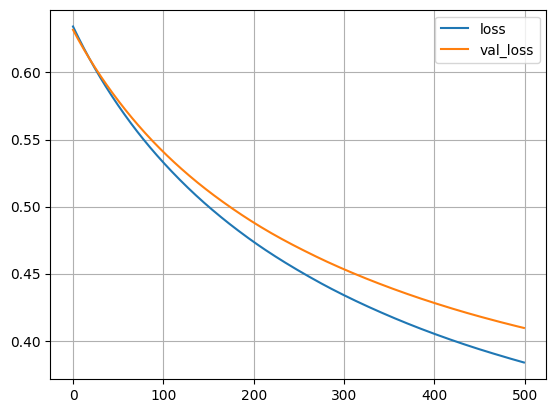

In [36]:
# Investigate Loss during training

cols_to_plot = ["loss", "val_loss"]  # 定义要绘制的列名，这里选择训练损失 ('loss') 和 验证损失 ('val_loss')

# 将 history.history 转换为 pandas DataFrame，并提取上面定义的列，绘制这两列的数据曲线
plt.plot(pd.DataFrame(history1.history)[cols_to_plot])

# 设置图例，使用 cols_to_plot 列表中的名称作为图例的标签，位置在右上角（'upper right'）
plt.legend(cols_to_plot, loc="upper right")

# 显示网格线，让图表更易于查看
plt.grid(True)


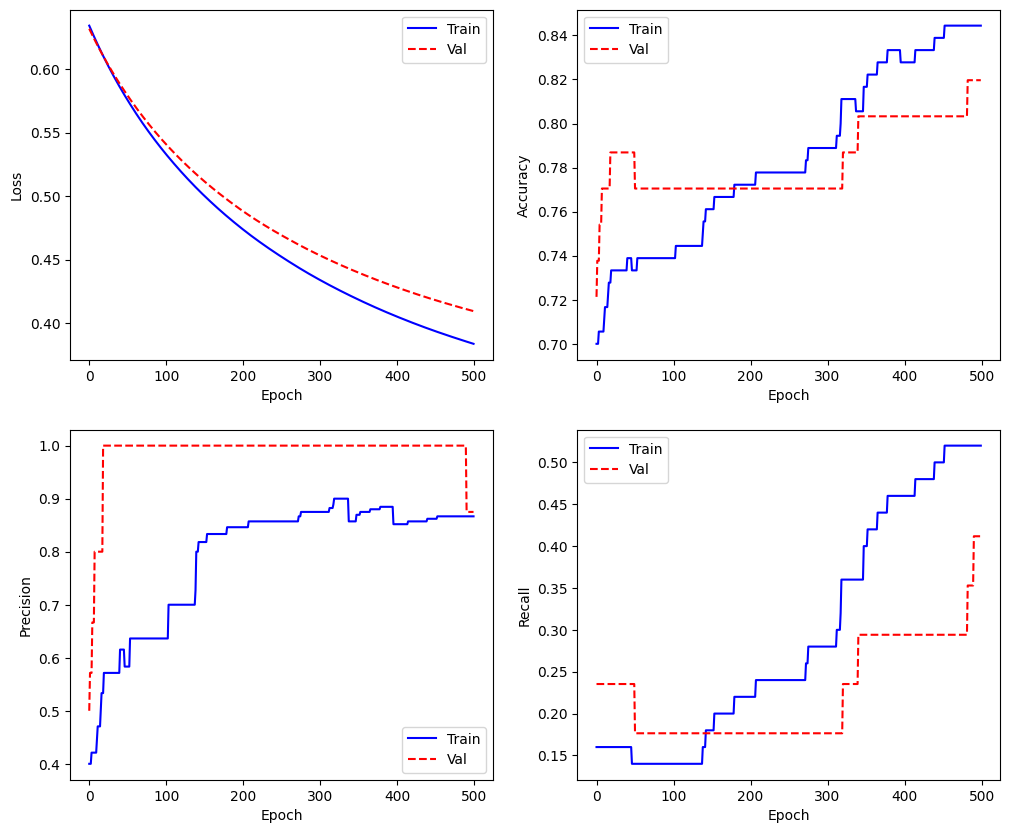

In [37]:
plot_metrics(history1)

In [38]:
# dataframe of two different loss functions
pd.DataFrame(history1.history)[cols_to_plot]

,loss,val_loss
0,0.634247,0.631780
1,0.632837,0.630510
2,0.631439,0.629250
3,0.630051,0.628001
4,0.628675,0.626762
...,...,...
495,0.384557,0.410188
496,0.384367,0.410024
497,0.384178,0.409862
498,0.383989,0.409699


## Experiment 2 - NN with Adam Optimizer:
- 1-Dense Hidden Layer, 32 units, `relu` activation function
- 1-Dense Output Layer, 1 unit, `sigmoid` activation function
- learning rate: 0.001
- __optimizer is Adam__
- metrics: 'accuracy', [precision](https://www.tensorflow.org/api_docs/python/tf/keras/metrics/Precision), [recall](https://www.tensorflow.org/api_docs/python/tf/keras/metrics/Recall)
- loss: [binary crossentropy](https://www.tensorflow.org/api_docs/python/tf/keras/losses/BinaryCrossentropy)
- epochs: 500
- batch size: 32
- use training data and validation data in `fit()` function
- use `predict()` on test data and show confusion matrix and classification reports


In [39]:
# Define model
model2 = tf.keras.models.Sequential(
    [
        tf.keras.layers.Dense(32, activation="relu", input_shape=X_train.shape[1:]),  # 8个特征 + 10种权重组合 - 生成换成10个神经元
        tf.keras.layers.Dense(1, activation="sigmoid")
    ]
)

# Compile model
adam_optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

model2.compile(
    loss='binary_crossentropy',
    optimizer=adam_optimizer,
    metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)

# Train model
history2 = model2.fit(
    X_train,
    y_train,
    batch_size=32,
    epochs=500,
    validation_data=(X_valid, y_valid)
)

Epoch 1/500


/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 209ms/step - accuracy: 0.3278 - loss: 0.8452 - precision_1: 0.0971 - recall_1: 0.1849 - val_accuracy: 0.3770 - val_loss: 0.7870 - val_precision_1: 0.1111 - val_recall_1: 0.1765
Epoch 2/500
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.4218 - loss: 0.7814 - precision_1: 0.1047 - recall_1: 0.1573 - val_accuracy: 0.5410 - val_loss: 0.7401 - val_precision_1: 0.1765 - val_recall_1: 0.1765
Epoch 3/500
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5380 - loss: 0.7285 - precision_1: 0.1016 - recall_1: 0.0987 - val_accuracy: 0.6066 - val_loss: 0.7003 - val_precision_1: 0.2308 - val_recall_1: 0.1765
Epoch 4/500
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6739 - loss: 0.6834 - precision_1: 0.2231 - recall_1: 0.0987 - val_accuracy: 0.6393 - val_loss: 0.6662 - val_precision_1: 0.0000e+00 - val_recall_1: 0.0000e+00
Epoch 5/500
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7184 - loss: 0.6448 - precision_1: 0.3514 - recall_1: 0.0987 - val_accuracy: 0

In [40]:
# Predict on the test data
y_pred_prob = model2.predict(X_test)  # Predict probabilities
y_pred = (y_pred_prob > 0.5).astype("int32")  # Convert probabilities to binary predictions (0 or 1)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


In [41]:
# Calculating the f1_score
from sklearn.metrics import confusion_matrix, classification_report, f1_score

f1_dt_bs = round(f1_score(y_test, y_pred, average='weighted') * 100, 2)
print('F1 Score of the model:', f1_dt_bs)
print('-' * 60)
print(classification_report(y_test, y_pred))
f1_dt_bs_class_0 = round(classification_report(y_test, y_pred, output_dict=True)['0']['f1-score'],2)
f1_dt_bs_class_1 = round(classification_report(y_test, y_pred, output_dict=True)['1']['f1-score'],2)
print('-' * 60)
pd.DataFrame(confusion_matrix(y_test, y_pred),
             columns=['No', 'Yes'], index=['No', 'Yes'])

F1 Score of the model: 82.96
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.87      0.91      0.89        44
           1       0.71      0.62      0.67        16

    accuracy                           0.83        60
   macro avg       0.79      0.77      0.78        60
weighted avg       0.83      0.83      0.83        60

------------------------------------------------------------


,No,Yes
No,40,4
Yes,6,10


In [42]:
# Validation on the test data set
test_result2 = model2.evaluate(X_test, y_test, verbose=0)         # verbose=0：不会显示任何输出。评估过程将默默运行。


# Print the results
print("Test Loss: {:.4f}".format(test_result2[0]))       # Loss (binary crossentropy)
print("Test Accuracy: {:.4f}".format(test_result2[1]))   # Accuracy
print("Test Precision: {:.4f}".format(test_result2[2]))  # Precision
print("Test Recall: {:.4f}".format(test_result2[3]))     # Recall

Test Loss: 0.7030
Test Accuracy: 0.8333
Test Precision: 0.7143
Test Recall: 0.6250


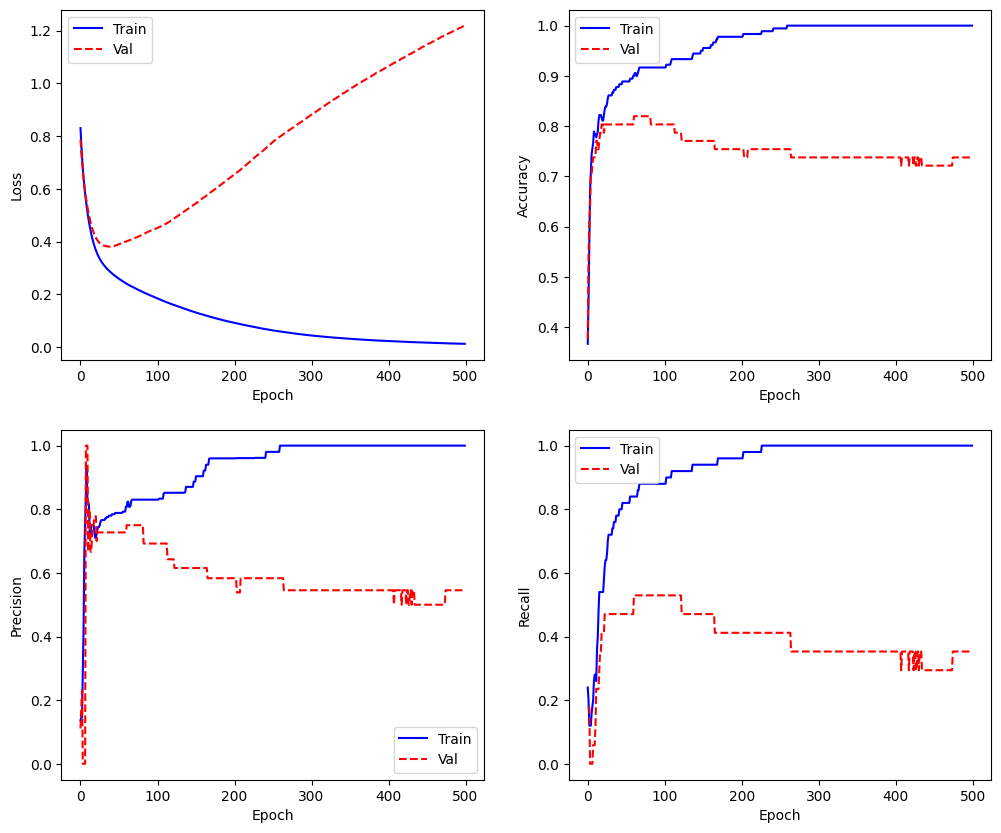

In [43]:
# Plotting learning Curves
plot_metrics(history2)

## Experiment 3 - Experiment with lower Learning Rate:
- 1-Dense Hidden Layer, 32 units, `relu` activation function
- 1-Dense Output Layer, 1 unit, `sigmoid` activation function
- __learning rate: 0.0001__
- __optimizer is Adam__
- metrics: 'accuracy', [precision](https://www.tensorflow.org/api_docs/python/tf/keras/metrics/Precision), [recall](https://www.tensorflow.org/api_docs/python/tf/keras/metrics/Recall)
- loss: [binary crossentropy](https://www.tensorflow.org/api_docs/python/tf/keras/losses/BinaryCrossentropy)
- epochs: 500
- batch size: 32
- use training data and validation data in `fit()` function
- use `predict()` on test data and show confusion matrix and classification reports

In [44]:
# Define model
model3 = tf.keras.models.Sequential(
    [
        tf.keras.layers.Dense(32, activation="relu", input_shape=X_train.shape[1:]),  # 8个特征 + 10种权重组合 - 生成换成10个神经元
        tf.keras.layers.Dense(1, activation="sigmoid")
    ]
)

# Compile model
adam_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

model3.compile(
    loss='binary_crossentropy',
    optimizer=adam_optimizer,
    metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)

# Train model
history3 = model3.fit(
    X_train,
    y_train,
    batch_size=32,
    epochs=500,
    validation_data=(X_valid, y_valid)
)

Epoch 1/500


/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 199ms/step - accuracy: 0.2556 - loss: 0.8798 - precision_2: 0.2172 - recall_2: 0.7063 - val_accuracy: 0.3443 - val_loss: 0.8210 - val_precision_2: 0.2830 - val_recall_2: 0.8824
Epoch 2/500
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.2715 - loss: 0.8712 - precision_2: 0.2211 - recall_2: 0.7063 - val_accuracy: 0.3443 - val_loss: 0.8139 - val_precision_2: 0.2830 - val_recall_2: 0.8824
Epoch 3/500
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.2775 - loss: 0.8630 - precision_2: 0.2218 - recall_2: 0.7006 - val_accuracy: 0.3443 - val_loss: 0.8069 - val_precision_2: 0.2830 - val_recall_2: 0.8824
Epoch 4/500
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.2775 - loss: 0.8549 - precision_2: 0.2218 - recall_2: 0.7006 - val_accuracy: 0.3443 - val_loss: 0.8001 - val_precision_2: 0.2830 - val_recall_2: 0.8824
Epoch 5/500
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.2990 - loss: 0.8469 - precision_2: 0.2276 - recall_2: 0.7006 - val_accuracy: 0.3443 - v

In [45]:
# Predict on the test data
y_pred_prob = model3.predict(X_test)  # Predict probabilities
y_pred = (y_pred_prob > 0.5).astype("int32")  # Convert probabilities to binary predictions (0 or 1)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


In [46]:
# Calculating the f1_score
from sklearn.metrics import confusion_matrix, classification_report, f1_score

f1_dt_bs = round(f1_score(y_test, y_pred, average='weighted') * 100, 2)
print('F1 Score of the model:', f1_dt_bs)
print('-' * 60)
print(classification_report(y_test, y_pred))
f1_dt_bs_class_0 = round(classification_report(y_test, y_pred, output_dict=True)['0']['f1-score'],2)
f1_dt_bs_class_1 = round(classification_report(y_test, y_pred, output_dict=True)['1']['f1-score'],2)
print('-' * 60)
pd.DataFrame(confusion_matrix(y_test, y_pred),
             columns=['No', 'Yes'], index=['No', 'Yes'])

F1 Score of the model: 81.94
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.84      0.95      0.89        44
           1       0.80      0.50      0.62        16

    accuracy                           0.83        60
   macro avg       0.82      0.73      0.75        60
weighted avg       0.83      0.83      0.82        60

------------------------------------------------------------


,No,Yes
No,42,2
Yes,8,8


In [47]:
# Validation on the test data set
test_result3 = model3.evaluate(X_test, y_test, verbose=0)         # verbose=0：不会显示任何输出。评估过程将默默运行。

# Print the results
print("Test Loss: {:.4f}".format(test_result3[0]))       # Loss (binary crossentropy)
print("Test Accuracy: {:.4f}".format(test_result3[1]))   # Accuracy
print("Test Precision: {:.4f}".format(test_result3[2]))  # Precision
print("Test Recall: {:.4f}".format(test_result3[3]))     # Recall


Test Loss: 0.3190
Test Accuracy: 0.8333
Test Precision: 0.8000
Test Recall: 0.5000


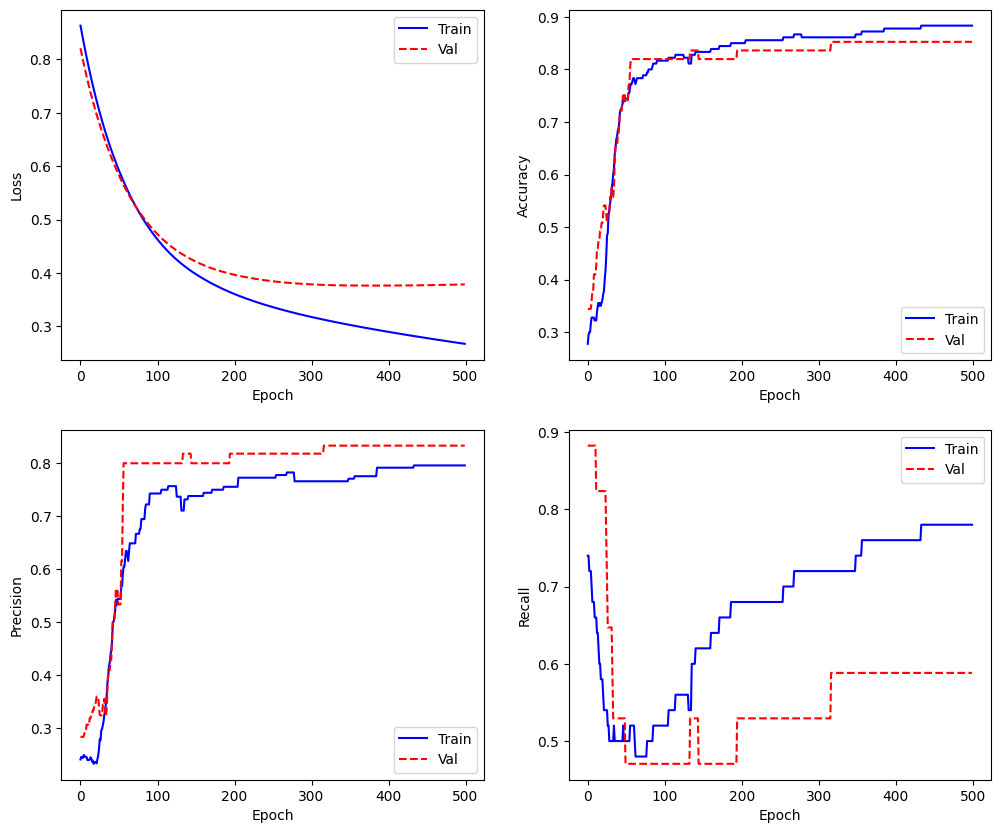

In [48]:
# Plotting learning Curves
plot_metrics(history3)

## Experiment 4 - Experiment with Early Stopping:
- 1-Dense Hidden Layer, 32 units, `relu` activation function
- 1-Dense Output Layer, 1 unit, `sigmoid` activation function
- __learning rate: 0.0001__
- __optimizer is Adam__
- metrics: 'accuracy', [precision](https://www.tensorflow.org/api_docs/python/tf/keras/metrics/Precision), [recall](https://www.tensorflow.org/api_docs/python/tf/keras/metrics/Recall)
- loss: [binary crossentropy](https://www.tensorflow.org/api_docs/python/tf/keras/losses/BinaryCrossentropy)
- __epochs: 10000__
- __Use the [early stopping](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping) callback to stop training as soon as the validation loss doesn't decrease after 10 epochs i.e. `patience=10` and `monitor='val_loss'`__
- batch size: 32
- use training data and validation data in `fit()` function
- use `predict()` on test data and show confusion matrix and classification reports


In [ ]:
# Define model
model4 = tf.keras.models.Sequential(
    [
        tf.keras.layers.Dense(32, activation="relu", input_shape=X_train.shape[1:]),  # 8个特征 + 10种权重组合 - 生成换成10个神经元
        tf.keras.layers.Dense(1, activation="sigmoid")
    ]
)

# Compile model
adam_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

model4.compile(
    loss='binary_crossentropy',
    optimizer=adam_optimizer,
    metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)

# Train model
history4 = model4.fit(
    X_train,
    y_train,
    batch_size=32,
    epochs=10000,
    validation_data=(X_valid, y_valid)
)

Epoch 1/10000


/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 197ms/step - accuracy: 0.6777 - loss: 0.6176 - precision_3: 0.4346 - recall_3: 0.7492 - val_accuracy: 0.6721 - val_loss: 0.6066 - val_precision_3: 0.4211 - val_recall_3: 0.4706
Epoch 2/10000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6718 - loss: 0.6121 - precision_3: 0.4269 - recall_3: 0.7216 - val_accuracy: 0.6885 - val_loss: 0.6023 - val_precision_3: 0.4444 - val_recall_3: 0.4706
Epoch 3/10000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6742 - loss: 0.6069 - precision_3: 0.4296 - recall_3: 0.7216 - val_accuracy: 0.7049 - val_loss: 0.5981 - val_precision_3: 0.4706 - val_recall_3: 0.4706
Epoch 4/10000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6742 - loss: 0.6019 - precision_3: 0.4296 - recall_3: 0.7216 - val_accuracy: 0.7049 - val_loss: 0.5939 - val_precision_3: 0.4706 - val_recall_3: 0.4706
Epoch 5/10000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6860 - loss: 0.5970 - precision_3: 0.4402 - recall_3: 0.7216 - val_accuracy: 0.

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 3.3038e-05 - precision_3: 1.0000 - recall_3: 1.0000 - val_accuracy: 0.7705 - val_loss: 2.6508 - val_precision_3: 0.6364 - val_recall_3: 0.4118
Epoch 6692/10000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 3.2975e-05 - precision_3: 1.0000 - recall_3: 1.0000 - val_accuracy: 0.7705 - val_loss: 2.6513 - val_precision_3: 0.6364 - val_recall_3: 0.4118
Epoch 6693/10000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 3.2909e-05 - precision_3: 1.0000 - recall_3: 1.0000 - val_accuracy: 0.7705 - val_loss: 2.6518 - val_precision_3: 0.6364 - val_recall_3: 0.4118
Epoch 6694/10000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 3.2850e-05 - precision_3: 1.0000 - recall_3: 1.0000 - val_accuracy: 0.7705 - val_loss: 2.6522 - val_precision_3: 0.6364 - val_recall_3: 0.4118
Epoch 6695/10000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 3.2788e-05 - precision_3: 1.0000 - recal

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 4.4097e-07 - precision_3: 1.0000 - recall_3: 1.0000 - val_accuracy: 0.7705 - val_loss: 3.5891 - val_precision_3: 0.6364 - val_recall_3: 0.4118
Epoch 9028/10000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 4.4040e-07 - precision_3: 1.0000 - recall_3: 1.0000 - val_accuracy: 0.7705 - val_loss: 3.5894 - val_precision_3: 0.6364 - val_recall_3: 0.4118
Epoch 9029/10000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 4.3955e-07 - precision_3: 1.0000 - recall_3: 1.0000 - val_accuracy: 0.7705 - val_loss: 3.5898 - val_precision_3: 0.6364 - val_recall_3: 0.4118
Epoch 9030/10000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 4.3901e-07 - precision_3: 1.0000 - recall_3: 1.0000 - val_accuracy: 0.7705 - val_loss: 3.5900 - val_precision_3: 0.6364 - val_recall_3: 0.4118
Epoch 9031/10000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 4.3821e-07 - precision_3: 1.0000 - recal

In [ ]:
# Predict on the test data
y_pred_prob = model4.predict(X_test)  # Predict probabilities
y_pred = (y_pred_prob > 0.5).astype("int32")  # Convert probabilities to binary predictions (0 or 1)

In [ ]:
# Calculating the f1_score
from sklearn.metrics import confusion_matrix, classification_report, f1_score

f1_dt_bs = round(f1_score(y_test, y_pred, average='weighted') * 100, 2)
print('F1 Score of the model:', f1_dt_bs)
print('-' * 60)
print(classification_report(y_test, y_pred))
f1_dt_bs_class_0 = round(classification_report(y_test, y_pred, output_dict=True)['0']['f1-score'],2)
f1_dt_bs_class_1 = round(classification_report(y_test, y_pred, output_dict=True)['1']['f1-score'],2)
print('-' * 60)
pd.DataFrame(confusion_matrix(y_test, y_pred),
             columns=['No', 'Yes'], index=['No', 'Yes'])

In [ ]:
# Evaluate the model on test data
test_result4 = model4.evaluate(X_test, y_test, verbose=0)

# Print the results
print("Test Loss: {:.4f}".format(test_result4[0]))       # Loss (binary crossentropy)
print("Test Accuracy: {:.4f}".format(test_result4[1]))   # Accuracy
print("Test Precision: {:.4f}".format(test_result4[2]))  # Precision
print("Test Recall: {:.4f}".format(test_result4[3]))     # Recall


In [ ]:
# Plotting learning Curves
plot_metrics(history4)

# Task 4: Training deep multi-layer Neural Networks

Run the following experiments separately to train multi-layer neural networks, evaluate the performance by looking at learning curve plots and finally check the performance of each of the following models on the test dataset.

Key workflow:

- Build model using architecture specification based on experiment
- Plot learning curves from model training to visualize performance over epochs on training and validation data
- Use trained model to predict and evaluate performance on test data
- Build separate models for each experiment

## Experiment 1 -  2-layer NN:  
- __2-Dense Hidden Layer, 32 units, `relu` activation function__
- 1-Dense Output Layer, 1 unit, `sigmoid` activation function
- __learning rate: 0.0001__
- __optimizer is Adam__
- metrics: 'accuracy', [precision](https://www.tensorflow.org/api_docs/python/tf/keras/metrics/Precision), [recall](https://www.tensorflow.org/api_docs/python/tf/keras/metrics/Recall)
- loss: [binary crossentropy](https://www.tensorflow.org/api_docs/python/tf/keras/losses/BinaryCrossentropy)
- __epochs: 10000__
- __Use the [early stopping](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping) callback to stop training as soon as the validation loss doesn't decrease after 10 epochs i.e. `patience=10` and `monitor='val_loss'`__
- batch size: 32
- use training data and validation data in `fit()` function
- use `predict()` on test data and show confusion matrix and classification reports


In [ ]:
# Define model
model5 = tf.keras.models.Sequential(
    [
        tf.keras.layers.Dense(32, activation="relu", input_shape=X_train.shape[1:]),
        tf.keras.layers.Dense(32, activation="relu"),
        tf.keras.layers.Dense(1, activation="sigmoid")
    ]
)

# Compile model
adam_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

model5.compile(
    loss='binary_crossentropy',
    optimizer=adam_optimizer,
    metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)

# Early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,         # Stop training if the validation loss doesn't improve after 10 epochs
    restore_best_weights=True  # Restore the weights from the epoch with the best validation loss
)

# Train model
history5 = model5.fit(
    X_train,
    y_train,
    batch_size=32,
    epochs=10000,
    validation_data=(X_valid, y_valid),
    callbacks=[early_stopping],
    verbose=1
)

In [ ]:
# Predict on the test data
y_pred_prob = model5.predict(X_test)  # Predict probabilities
y_pred = (y_pred_prob > 0.5).astype("int32")  # Convert probabilities to binary predictions (0 or 1)

In [ ]:
# Calculating the f1_score
from sklearn.metrics import confusion_matrix, classification_report, f1_score

f1_dt_bs = round(f1_score(y_test, y_pred, average='weighted') * 100, 2)
print('F1 Score of the model:', f1_dt_bs)
print('-' * 60)
print(classification_report(y_test, y_pred))
f1_dt_bs_class_0 = round(classification_report(y_test, y_pred, output_dict=True)['0']['f1-score'],2)
f1_dt_bs_class_1 = round(classification_report(y_test, y_pred, output_dict=True)['1']['f1-score'],2)
print('-' * 60)
pd.DataFrame(confusion_matrix(y_test, y_pred),
             columns=['No', 'Yes'], index=['No', 'Yes'])

In [ ]:
# Validation on the test data set
test_result5 = model5.evaluate(X_test, y_test, verbose=0)         # verbose=0：不会显示任何输出。评估过程将默默运行。


# Print the results
print("Test Loss: {:.4f}".format(test_result5[0]))       # Loss (binary crossentropy)
print("Test Accuracy: {:.4f}".format(test_result5[1]))   # Accuracy
print("Test Precision: {:.4f}".format(test_result5[2]))  # Precision
print("Test Recall: {:.4f}".format(test_result5[3]))     # Recall

In [ ]:
# Plotting learning Curves
plot_metrics(history5)

## Experiment 2 -  3-layer NN:  
- __3-Dense Hidden Layer, 32 units, `relu` activation function__
- 1-Dense Output Layer, 1 unit, `sigmoid` activation function
- __learning rate: 0.0001__
- __optimizer is Adam__
- metrics: 'accuracy', [precision](https://www.tensorflow.org/api_docs/python/tf/keras/metrics/Precision), [recall](https://www.tensorflow.org/api_docs/python/tf/keras/metrics/Recall)
- loss: [binary crossentropy](https://www.tensorflow.org/api_docs/python/tf/keras/losses/BinaryCrossentropy)
- __epochs: 10000__
- __Use the [early stopping](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping) callback to stop training as soon as the validation loss doesn't decrease after 10 epochs i.e. `patience=10` and `monitor='val_loss'`__
- batch size: 32
- use training data and validation data in `fit()` function
- use `predict()` on test data and show confusion matrix and classification reports

In [59]:
# Define model
model6 = tf.keras.models.Sequential(
    [
        tf.keras.layers.Dense(32, activation="relu", input_shape=X_train.shape[1:]),
        tf.keras.layers.Dense(32, activation="relu"),
        tf.keras.layers.Dense(32, activation="relu"),
        tf.keras.layers.Dense(1, activation="sigmoid")
    ]
)

# Compile model
adam_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

model6.compile(
    loss='binary_crossentropy',
    optimizer=adam_optimizer,
    metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)

# Early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,         # Stop training if the validation loss doesn't improve after 10 epochs
    restore_best_weights=True  # Restore the weights from the epoch with the best validation loss
)

# Train model
history6 = model6.fit(
    X_train,
    y_train,
    batch_size=32,
    epochs=10000,
    validation_data=(X_valid, y_valid),
    callbacks=[early_stopping],
    verbose=1
)

6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 263ms/step - accuracy: 0.4865 - loss: 0.7032 - precision_5: 0.3107 - recall_5: 0.7851 - val_accuracy: 0.5902 - val_loss: 0.6797 - val_precision_5: 0.3750 - val_recall_5: 0.7059
Epoch 2/10000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4906 - loss: 0.6950 - precision_5: 0.3095 - recall_5: 0.7631 - val_accuracy: 0.6230 - val_loss: 0.6738 - val_precision_5: 0.4000 - val_recall_5: 0.7059
Epoch 3/10000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5310 - loss: 0.6875 - precision_5: 0.3013 - recall_5: 0.5979 - val_accuracy: 0.6885 - val_loss: 0.6683 - val_precision_5: 0.4583 - val_recall_5: 0.6471
Epoch 4/10000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5605 - loss: 0.6802 - precision_5: 0.3182 - recall_5: 0.5922 - val_accuracy: 0.6721 - val_loss: 0.6629 - val_precision_5: 0.4348 - val_recall_5: 0.5882
Epoch 5/10000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6209 - loss: 0.6731 - precision_5: 0.3499 - recall_5: 0.5468 - val_accuracy: 0.

In [60]:
# Predict on the test data
y_pred_prob = model6.predict(X_test)  # Predict probabilities
y_pred = (y_pred_prob > 0.5).astype("int32")  # Convert probabilities to binary predictions (0 or 1)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


In [61]:
# Calculating the f1_score
from sklearn.metrics import confusion_matrix, classification_report, f1_score

f1_dt_bs = round(f1_score(y_test, y_pred, average='weighted') * 100, 2)
print('F1 Score of the model:', f1_dt_bs)
print('-' * 60)
print(classification_report(y_test, y_pred))
f1_dt_bs_class_0 = round(classification_report(y_test, y_pred, output_dict=True)['0']['f1-score'],2)
f1_dt_bs_class_1 = round(classification_report(y_test, y_pred, output_dict=True)['1']['f1-score'],2)
print('-' * 60)
pd.DataFrame(confusion_matrix(y_test, y_pred),
             columns=['No', 'Yes'], index=['No', 'Yes'])

F1 Score of the model: 89.78
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.91      0.95      0.93        44
           1       0.86      0.75      0.80        16

    accuracy                           0.90        60
   macro avg       0.89      0.85      0.87        60
weighted avg       0.90      0.90      0.90        60

------------------------------------------------------------


,No,Yes
No,42,2
Yes,4,12


In [62]:
# Validation on the test data set
test_result6 = model6.evaluate(X_test, y_test, verbose=0)         # verbose=0：不会显示任何输出。评估过程将默默运行。


# Print the results
print("Test Loss: {:.4f}".format(test_result6[0]))       # Loss (binary crossentropy)
print("Test Accuracy: {:.4f}".format(test_result6[1]))   # Accuracy
print("Test Precision: {:.4f}".format(test_result6[2]))  # Precision
print("Test Recall: {:.4f}".format(test_result6[3]))     # Recall

Test Loss: 0.2850
Test Accuracy: 0.9000
Test Precision: 0.8571
Test Recall: 0.7500


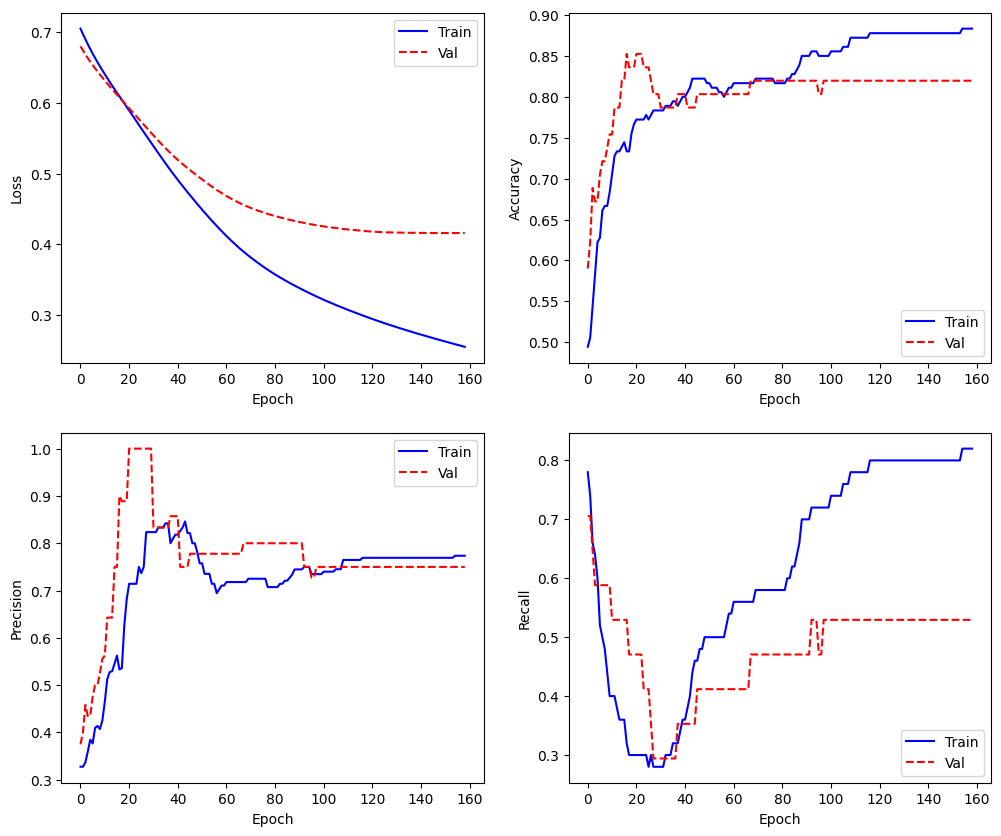

In [63]:
# Plotting learning Curves
plot_metrics(history6)

# Task 5: Training deep multi-layer Neural Networks with Class Weights to tackle Class Imbalance

We know that our dataset is heavily imbalanced between the two classes, feel free to leverage the`class_weight` parameter in the `model.fit()` function and experiment with your own weights or use [compute class weight](https://scikit-learn.org/stable/modules/generated/sklearn.utils.class_weight.compute_class_weight.html) from `sklearn`


Run the following experiment to train multi-layer neural networks, evaluate the performance by looking at learning curve plots and finally check the performance of each of the following models on the test dataset.

Key workflow:

- Build model using architecture specification based on experiment
- Plot learning curves from model training to visualize performance over epochs on training and validation data
- Use trained model to predict and evaluate performance on test data
- Play around with the `class_weight` parameter when training


### Experiment 1 -  3-layer NN:  
- __3-Dense Hidden Layer, 32 units, `relu` activation function__
- 1-Dense Output Layer, 1 unit, `sigmoid` activation function
- __learning rate: 0.0001__
- __optimizer is Adam__
- metrics: 'accuracy', [precision](https://www.tensorflow.org/api_docs/python/tf/keras/metrics/Precision), [recall](https://www.tensorflow.org/api_docs/python/tf/keras/metrics/Recall)
- loss: [binary crossentropy](https://www.tensorflow.org/api_docs/python/tf/keras/losses/BinaryCrossentropy)
- __epochs: 10000__
- __Use the [early stopping](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping) callback to stop training as soon as the validation loss doesn't decrease after 10 epochs i.e. `patience=10` and `monitor='val_loss'`__
- __Modify `class_weight` in `model.fit()`__
- batch size: 32
- use training data and validation data in `fit()` function
- use `predict()` on test data and show confusion matrix and classification reports


## Complete Task 5 Below

In [126]:
# compute_class_weight
from sklearn.utils import class_weight
class_weight = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(y_train.values), y=y_train.values.ravel())
class_weight = dict(enumerate(class_weight))
class_weight

{0: 0.6923076923076923, 1: 1.8}

In [87]:
y_valid.value_counts()

target
0    44
1    17
Name: count, dtype: int64

In [88]:
y_train.value_counts()

target
0    130
1     50
Name: count, dtype: int64

In [139]:
y_train = np.asarray(y_train).astype(int)
y_valid = np.asarray(y_valid).astype(int)
y_test = np.asarray(y_test).astype(int)

In [141]:
# Define model
model7 = tf.keras.models.Sequential(
    [
        tf.keras.layers.Dense(32, activation="relu", input_shape=X_train.shape[1:]),
        tf.keras.layers.Dense(32, activation="relu"),
        tf.keras.layers.Dense(32, activation="relu"),
        tf.keras.layers.Dense(1, activation="sigmoid")
    ]
)

# Compile model
adam_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

model7.compile(
    loss='binary_crossentropy',
    optimizer=adam_optimizer,
    metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)

# Early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,         # Stop training if the validation loss doesn't improve after 10 epochs
    restore_best_weights=True  # Restore the weights from the epoch with the best validation loss
)

# Train model
history7 = model7.fit(
    X_train,
    y_train,
    batch_size=32,
    epochs=10000,
    validation_data=(X_valid, y_valid),
    callbacks=[early_stopping],
    class_weight=class_weight,
    verbose=1
)

Epoch 1/10000


/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 228ms/step - accuracy: 0.3866 - loss: 0.7274 - precision_14: 0.1743 - recall_14: 0.3599 - val_accuracy: 0.5246 - val_loss: 0.7102 - val_precision_14: 0.3125 - val_recall_14: 0.5882
Epoch 2/10000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.3809 - loss: 0.7203 - precision_14: 0.1730 - recall_14: 0.3599 - val_accuracy: 0.5246 - val_loss: 0.7051 - val_precision_14: 0.3125 - val_recall_14: 0.5882
Epoch 3/10000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.3958 - loss: 0.7140 - precision_14: 0.1782 - recall_14: 0.3599 - val_accuracy: 0.5410 - val_loss: 0.7003 - val_precision_14: 0.3226 - val_recall_14: 0.5882
Epoch 4/10000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.3848 - loss: 0.7081 - precision_14: 0.1676 - recall_14: 0.3388 - val_accuracy: 0.5410 - val_loss: 0.6958 - val_precision_14: 0.3226 - val_recall_14: 0.5882
Epoch 5/10000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.3924 - loss: 0.7024 - precision_14: 0.1732 - recall_14: 0.3478 

In [142]:
# Predict on the test data
y_pred_prob = model7.predict(X_test)  # Predict probabilities
y_pred = (y_pred_prob > 0.5).astype("int32")  # Convert probabilities to binary predictions (0 or 1)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


In [143]:
# Calculating the f1_score
from sklearn.metrics import confusion_matrix, classification_report, f1_score

f1_dt_bs = round(f1_score(y_test, y_pred, average='weighted') * 100, 2)
print('F1 Score of the model:', f1_dt_bs)
print('-' * 60)
print(classification_report(y_test, y_pred))
f1_dt_bs_class_0 = round(classification_report(y_test, y_pred, output_dict=True)['0']['f1-score'],2)
f1_dt_bs_class_1 = round(classification_report(y_test, y_pred, output_dict=True)['1']['f1-score'],2)
print('-' * 60)
pd.DataFrame(confusion_matrix(y_test, y_pred),
             columns=['No', 'Yes'], index=['No', 'Yes'])

F1 Score of the model: 88.44
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.93      0.91      0.92        44
           1       0.76      0.81      0.79        16

    accuracy                           0.88        60
   macro avg       0.85      0.86      0.85        60
weighted avg       0.89      0.88      0.88        60

------------------------------------------------------------


,No,Yes
No,40,4
Yes,3,13


In [144]:
X_test.shape

(60, 27)

In [145]:
y_test.shape

(60,)

In [147]:
# Validation on the test data set
test_result7 = model7.evaluate(X_test, y_test, verbose=0)         # verbose=0：不会显示任何输出。评估过程将默默运行。


# Print the results
print("Test Loss: {:.4f}".format(test_result7[0]))       # Loss (binary crossentropy)
print("Test Accuracy: {:.4f}".format(test_result7[1]))   # Accuracy
print("Test Precision: {:.4f}".format(test_result7[2]))  # Precision
print("Test Recall: {:.4f}".format(test_result7[3]))     # Recall

Test Loss: 0.2768
Test Accuracy: 0.8833
Test Precision: 0.7647
Test Recall: 0.8125


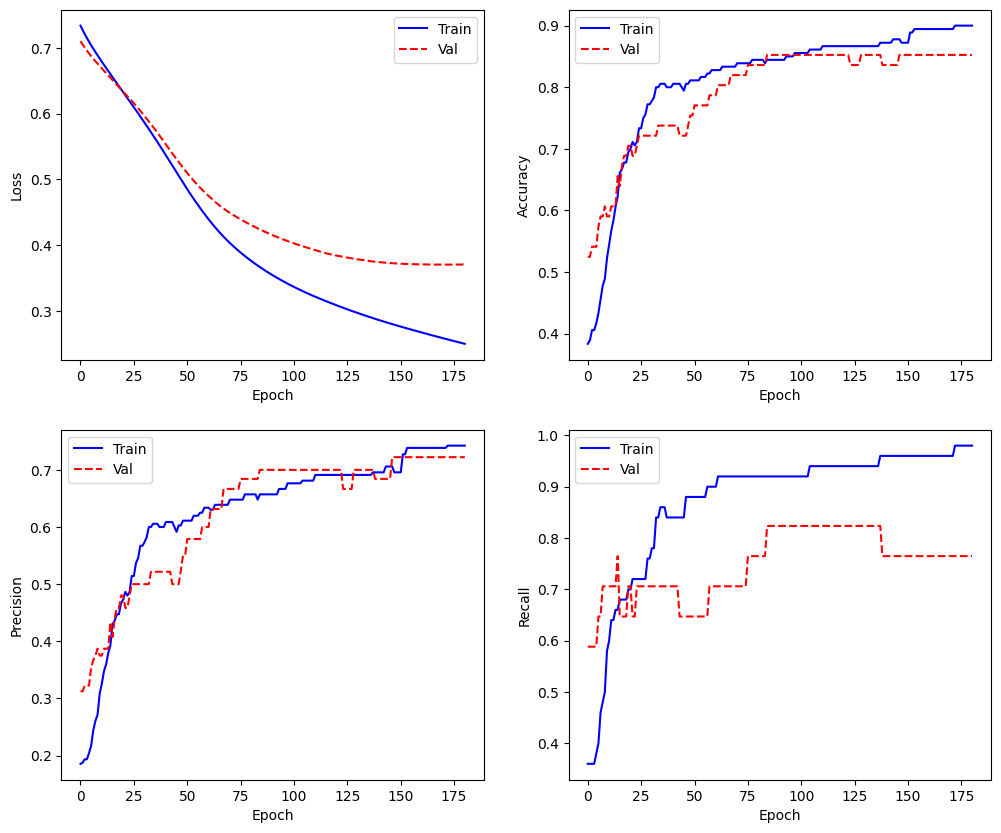

In [149]:
# Plotting learning Curves
plot_metrics(history7)

# Day 2

# Task 6: Experimenting with NN layer activation functions

_[We know that our dataset is heavily imbalanced between the two classes, feel free to leverage the`class_weight` parameter in the `model.fit()` function and experiment with your own weights or use [compute class weight](https://scikit-learn.org/stable/modules/generated/sklearn.utils.class_weight.compute_class_weight.html) from `sklearn`]_

__Run the following experiments separately to train multi-layer neural networks with different activation functions__, evaluate the performance by looking at learning curve plots and finally check the performance of each of the following models on the test dataset.

Key workflow:

- Build model using architecture specification based on experiment
- Plot learning curves from model training to visualize performance over epochs on training and validation data
- Use trained model to predict and evaluate performance on test data
- Build separate models for each experiment


## Experiment 1 -  3-layer NN with elu activation:  
- __3-Dense Hidden Layer, 32 units, `elu` activation function and `he_normal` as the kernel_initializer__
- 1-Dense Output Layer, 1 unit, `sigmoid` activation function
- __learning rate: 0.0001__
- __optimizer is Adam__
- metrics: 'accuracy', [precision](https://www.tensorflow.org/api_docs/python/tf/keras/metrics/Precision), [recall](https://www.tensorflow.org/api_docs/python/tf/keras/metrics/Recall)
- loss: [binary crossentropy](https://www.tensorflow.org/api_docs/python/tf/keras/losses/BinaryCrossentropy)
- __epochs: 10000__
- __Use the [early stopping](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping) callback to stop training as soon as the validation loss doesn't decrease after 10 epochs i.e. `patience=10` and `monitor='val_loss'`__
- __Modify `class_weight` in `model.fit()`__
- batch size: 32
- use training data and validation data in `fit()` function
- use `predict()` on test data and show confusion matrix and classification reports


In [150]:
# Define model
model8 = tf.keras.models.Sequential(
    [
        tf.keras.layers.Flatten(input_shape=X_train.shape[1:]),
        tf.keras.layers.Dense(32, activation="elu", kernel_initializer="he_normal"),
        tf.keras.layers.Dense(32, activation="elu", kernel_initializer="he_normal"),
        tf.keras.layers.Dense(32, activation="elu", kernel_initializer="he_normal"),
        tf.keras.layers.Dense(1, activation="sigmoid")
    ]
)

# Compile model
adam_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

model8.compile(
    loss='binary_crossentropy',
    optimizer=adam_optimizer,
    metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)

# Early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,         # Stop training if the validation loss doesn't improve after 10 epochs
    restore_best_weights=True  # Restore the weights from the epoch with the best validation loss
)

# Train model
history8 = model8.fit(
    X_train,
    y_train,
    batch_size=32,
    epochs=10000,
    validation_data=(X_valid, y_valid),
    class_weight=class_weight,
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/10000


/opt/conda/lib/python3.10/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 222ms/step - accuracy: 0.4049 - loss: 1.1840 - precision_15: 0.0370 - recall_15: 0.0489 - val_accuracy: 0.5082 - val_loss: 0.9560 - val_precision_15: 0.1579 - val_recall_15: 0.1765
Epoch 2/10000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4049 - loss: 1.1435 - precision_15: 0.0370 - recall_15: 0.0489 - val_accuracy: 0.4590 - val_loss: 0.9386 - val_precision_15: 0.1364 - val_recall_15: 0.1765
Epoch 3/10000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4174 - loss: 1.1060 - precision_15: 0.0566 - recall_15: 0.0758 - val_accuracy: 0.4426 - val_loss: 0.9220 - val_precision_15: 0.1304 - val_recall_15: 0.1765
Epoch 4/10000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4135 - loss: 1.0702 - precision_15: 0.0643 - recall_15: 0.0889 - val_accuracy: 0.4426 - val_loss: 0.9062 - val_precision_15: 0.1304 - val_recall_15: 0.1765
Epoch 5/10000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4329 - loss: 1.0361 - precision_15: 0.0995 - recall_15: 0.1427 

In [151]:
# Predict on the test data
y_pred_prob = model8.predict(X_test)  # Predict probabilities
y_pred = (y_pred_prob > 0.5).astype("int32")  # Convert probabilities to binary predictions (0 or 1)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


In [152]:
# Calculating the f1_score
from sklearn.metrics import confusion_matrix, classification_report, f1_score

f1_dt_bs = round(f1_score(y_test, y_pred, average='weighted') * 100, 2)
print('F1 Score of the model:', f1_dt_bs)
print('-' * 60)
print(classification_report(y_test, y_pred))
f1_dt_bs_class_0 = round(classification_report(y_test, y_pred, output_dict=True)['0']['f1-score'],2)
f1_dt_bs_class_1 = round(classification_report(y_test, y_pred, output_dict=True)['1']['f1-score'],2)
print('-' * 60)
pd.DataFrame(confusion_matrix(y_test, y_pred),
             columns=['No', 'Yes'], index=['No', 'Yes'])

F1 Score of the model: 88.21
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.91      0.93      0.92        44
           1       0.80      0.75      0.77        16

    accuracy                           0.88        60
   macro avg       0.86      0.84      0.85        60
weighted avg       0.88      0.88      0.88        60

------------------------------------------------------------


,No,Yes
No,41,3
Yes,4,12


In [153]:
# Validation on the test data set
test_result8 = model8.evaluate(X_test, y_test, verbose=0)         # verbose=0：不会显示任何输出。评估过程将默默运行。


# Print the results
print("Test Loss: {:.4f}".format(test_result8[0]))       # Loss (binary crossentropy)
print("Test Accuracy: {:.4f}".format(test_result8[1]))   # Accuracy
print("Test Precision: {:.4f}".format(test_result8[2]))  # Precision
print("Test Recall: {:.4f}".format(test_result8[3]))     # Recall

Test Loss: 0.2863
Test Accuracy: 0.8833
Test Precision: 0.8000
Test Recall: 0.7500


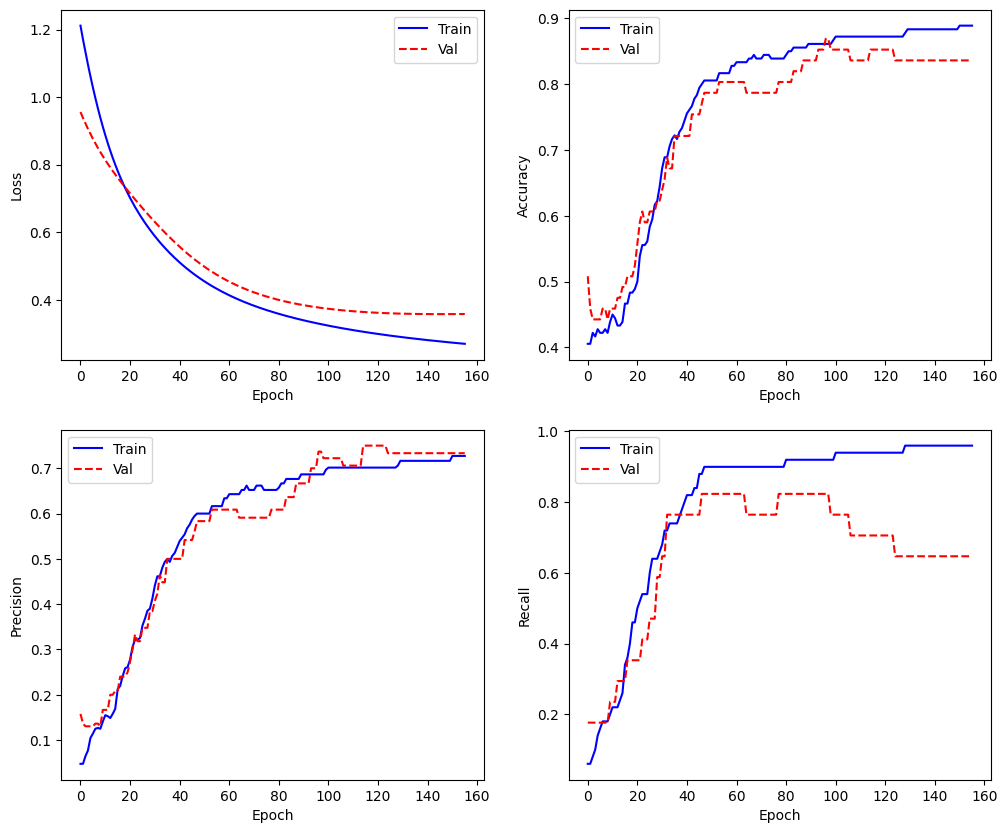

In [154]:
# Plotting learning Curves
plot_metrics(history8)

## Experiment 2 -  3-layer NN with leakyrelu activation:  
- __3-Dense Hidden Layer, 32 units, LeakyReLU(alpha=0.3) activation function and `he_normal` as the kernel_initializer__
- 1-Dense Output Layer, 1 unit, `sigmoid` activation function
- __learning rate: 0.0001__
- __optimizer is Adam__
- metrics: 'accuracy', [precision](https://www.tensorflow.org/api_docs/python/tf/keras/metrics/Precision), [recall](https://www.tensorflow.org/api_docs/python/tf/keras/metrics/Recall)
- loss: [binary crossentropy](https://www.tensorflow.org/api_docs/python/tf/keras/losses/BinaryCrossentropy)
- __epochs: 10000__
- __Use the [early stopping](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping) callback to stop training as soon as the validation loss doesn't decrease after 10 epochs i.e. `patience=10` and `monitor='val_loss'`__
- __Modify `class_weight` in `model.fit()`__
- batch size: 32
- use training data and validation data in `fit()` function
- use `predict()` on test data and show confusion matrix and classification reports

In [156]:
# Define model
model9 = tf.keras.models.Sequential(
    [
        tf.keras.layers.Flatten(input_shape=X_train.shape[1:]),
        tf.keras.layers.Dense(32, activation=tf.keras.layers.LeakyReLU(alpha=0.3), kernel_initializer="he_normal"),
        tf.keras.layers.Dense(32, activation=tf.keras.layers.LeakyReLU(alpha=0.3), kernel_initializer="he_normal"),
        tf.keras.layers.Dense(32, activation=tf.keras.layers.LeakyReLU(alpha=0.3), kernel_initializer="he_normal"),
        tf.keras.layers.Dense(1, activation="sigmoid")
    ]
)

# Compile model
adam_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

model9.compile(
    loss='binary_crossentropy',
    optimizer=adam_optimizer,
    metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)

# Early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,         # Stop training if the validation loss doesn't improve after 10 epochs
    restore_best_weights=True  # Restore the weights from the epoch with the best validation loss
)

# Train model
history9 = model9.fit(
    X_train,
    y_train,
    batch_size=32,
    epochs=10000,
    validation_data=(X_valid, y_valid),
    class_weight = class_weight,
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/10000


/opt/conda/lib/python3.10/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/opt/conda/lib/python3.10/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 257ms/step - accuracy: 0.5488 - loss: 0.6412 - precision_16: 0.3213 - recall_16: 0.6322 - val_accuracy: 0.5574 - val_loss: 0.6991 - val_precision_16: 0.3214 - val_recall_16: 0.5294
Epoch 2/10000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5688 - loss: 0.6291 - precision_16: 0.3387 - recall_16: 0.6507 - val_accuracy: 0.5738 - val_loss: 0.6869 - val_precision_16: 0.3448 - val_recall_16: 0.5882
Epoch 3/10000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5839 - loss: 0.6186 - precision_16: 0.3538 - recall_16: 0.6692 - val_accuracy: 0.6066 - val_loss: 0.6755 - val_precision_16: 0.3704 - val_recall_16: 0.5882
Epoch 4/10000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6091 - loss: 0.6086 - precision_16: 0.3804 - recall_16: 0.7290 - val_accuracy: 0.6066 - val_loss: 0.6646 - val_precision_16: 0.3704 - val_recall_16: 0.5882
Epoch 5/10000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6384 - loss: 0.5991 - precision_16: 0.4073 - recall_16: 0.7559 

In [157]:
# Predict on the test data
y_pred_prob = model9.predict(X_test)  # Predict probabilities
y_pred = (y_pred_prob > 0.5).astype("int32")  # Convert probabilities to binary predictions (0 or 1)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


In [158]:
# Calculating the f1_score
from sklearn.metrics import confusion_matrix, classification_report, f1_score

f1_dt_bs = round(f1_score(y_test, y_pred, average='weighted') * 100, 2)
print('F1 Score of the model:', f1_dt_bs)
print('-' * 60)
print(classification_report(y_test, y_pred))
f1_dt_bs_class_0 = round(classification_report(y_test, y_pred, output_dict=True)['0']['f1-score'],2)
f1_dt_bs_class_1 = round(classification_report(y_test, y_pred, output_dict=True)['1']['f1-score'],2)
print('-' * 60)
pd.DataFrame(confusion_matrix(y_test, y_pred),
             columns=['No', 'Yes'], index=['No', 'Yes'])

F1 Score of the model: 88.44
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.93      0.91      0.92        44
           1       0.76      0.81      0.79        16

    accuracy                           0.88        60
   macro avg       0.85      0.86      0.85        60
weighted avg       0.89      0.88      0.88        60

------------------------------------------------------------


,No,Yes
No,40,4
Yes,3,13


In [159]:
# Validation on the test data set
test_result9 = model9.evaluate(X_test, y_test, verbose=0)         # verbose=0：不会显示任何输出。评估过程将默默运行。


# Print the results
print("Test Loss: {:.4f}".format(test_result9[0]))       # Loss (binary crossentropy)
print("Test Accuracy: {:.4f}".format(test_result9[1]))   # Accuracy
print("Test Precision: {:.4f}".format(test_result9[2]))  # Precision
print("Test Recall: {:.4f}".format(test_result9[3]))     # Recall

Test Loss: 0.2869
Test Accuracy: 0.8833
Test Precision: 0.7647
Test Recall: 0.8125


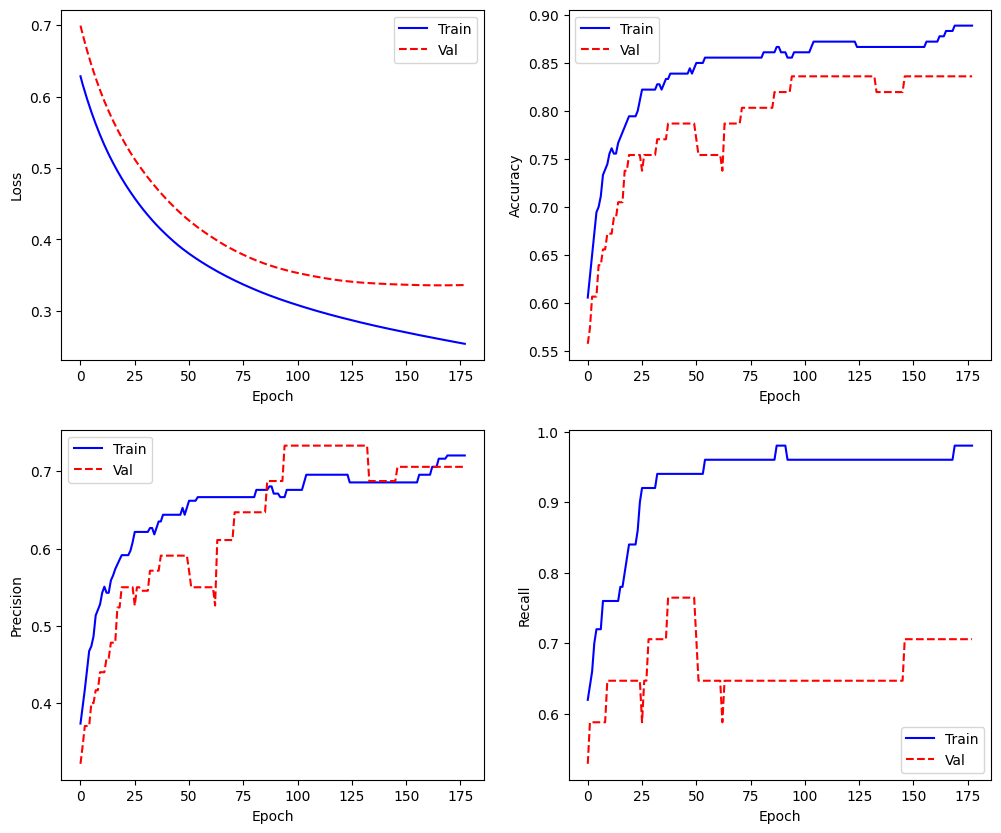

In [160]:
# Plotting learning Curves
plot_metrics(history9)

# Task 7: Regularization in NNs

_[We know that our dataset is heavily imbalanced between the two classes, feel free to leverage the`class_weight` parameter in the `model.fit()` function and experiment with your own weights or use [compute class weight](https://scikit-learn.org/stable/modules/generated/sklearn.utils.class_weight.compute_class_weight.html) from `sklearn`]_

__Run the following experiments separately to train multi-layer neural networks with different methods of regularization__, evaluate the performance by looking at learning curve plots and finally check the performance of each of the following models on the test dataset.

We will try the following methods for regularization:
- BatchNormalization
- Dropout
- Layer regularizer with L2 kernel

Key workflow:

- Build model using architecture specification based on experiment
- Plot learning curves from model training to visualize performance over epochs on training and validation data
- Use trained model to predict and evaluate performance on test data
- Build separate models for each experiment

### Experiment 1 -  3-layer NN with BatchNorm:  
- __3-Dense Hidden Layer, 32 units, `relu` activation function__
- __Add batchnorm layer after each hidden layer__
- 1-Dense Output Layer, 1 unit, `sigmoid` activation function
- __learning rate: 0.0001__
- __optimizer is Adam__
- metrics: 'accuracy', [precision](https://www.tensorflow.org/api_docs/python/tf/keras/metrics/Precision), [recall](https://www.tensorflow.org/api_docs/python/tf/keras/metrics/Recall)
- loss: [binary crossentropy](https://www.tensorflow.org/api_docs/python/tf/keras/losses/BinaryCrossentropy)
- __epochs: 10000__
- __Use the [early stopping](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping) callback to stop training as soon as the validation loss doesn't decrease after 10 epochs i.e. `patience=10` and `monitor='val_loss'`__
- __Modify `class_weight` in `model.fit()`__
- batch size: 32
- use training data and validation data in `fit()` function
- use `predict()` on test data and show confusion matrix and classification reports

In [161]:
# Define model
model10 = tf.keras.models.Sequential(
    [
        tf.keras.layers.Flatten(input_shape=X_train.shape[1:]),

        # 1st Dense Layer
        tf.keras.layers.Dense(32, kernel_initializer="he_normal"),
        tf.keras.layers.ReLU(),
        tf.keras.layers.BatchNormalization(),

        # 2nd Dense Layer
        tf.keras.layers.Dense(32, kernel_initializer="he_normal"),
        tf.keras.layers.ReLU(),
        tf.keras.layers.BatchNormalization(),

        # 3rd Dense Layer
        tf.keras.layers.Dense(32, kernel_initializer="he_normal"),
        tf.keras.layers.ReLU(),
        tf.keras.layers.BatchNormalization(),

        tf.keras.layers.Dense(1, activation="sigmoid")
    ]
)


# Compile model
adam_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

model10.compile(
    loss='binary_crossentropy',
    optimizer=adam_optimizer,
    metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)

# Early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,         # Stop training if the validation loss doesn't improve after 10 epochs
    restore_best_weights=True  # Restore the weights from the epoch with the best validation loss
)

# Train model
history10 = model10.fit(
    X_train,
    y_train,
    batch_size=32,
    epochs=10000,
    validation_data=(X_valid, y_valid),
    class_weight=class_weight,
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/10000


/opt/conda/lib/python3.10/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 339ms/step - accuracy: 0.3315 - loss: 1.0968 - precision_17: 0.1445 - recall_17: 0.3099 - val_accuracy: 0.5246 - val_loss: 0.7546 - val_precision_17: 0.2000 - val_recall_17: 0.2353
Epoch 2/10000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.3351 - loss: 1.0630 - precision_17: 0.1497 - recall_17: 0.3229 - val_accuracy: 0.5246 - val_loss: 0.7575 - val_precision_17: 0.2273 - val_recall_17: 0.2941
Epoch 3/10000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.3351 - loss: 1.0340 - precision_17: 0.1497 - recall_17: 0.3229 - val_accuracy: 0.5082 - val_loss: 0.7607 - val_precision_17: 0.2174 - val_recall_17: 0.2941
Epoch 4/10000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.3351 - loss: 1.0063 - precision_17: 0.1497 - recall_17: 0.3229 - val_accuracy: 0.4918 - val_loss: 0.7638 - val_precision_17: 0.2083 - val_recall_17: 0.2941
Epoch 5/10000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.3461 - loss: 0.9796 - precision_17: 0.1529 - recall_17: 0.3229 

In [162]:
# Predict on the test data
y_pred_prob = model10.predict(X_test)  # Predict probabilities
y_pred = (y_pred_prob > 0.5).astype("int32")  # Convert probabilities to binary predictions (0 or 1)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


In [163]:
# Calculating the f1_score
from sklearn.metrics import confusion_matrix, classification_report, f1_score

f1_dt_bs = round(f1_score(y_test, y_pred, average='weighted') * 100, 2)
print('F1 Score of the model:', f1_dt_bs)
print('-' * 60)
print(classification_report(y_test, y_pred))
f1_dt_bs_class_0 = round(classification_report(y_test, y_pred, output_dict=True)['0']['f1-score'],2)
f1_dt_bs_class_1 = round(classification_report(y_test, y_pred, output_dict=True)['1']['f1-score'],2)
print('-' * 60)
pd.DataFrame(confusion_matrix(y_test, y_pred),
             columns=['No', 'Yes'], index=['No', 'Yes'])

F1 Score of the model: 57.9
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.71      0.73      0.72        44
           1       0.20      0.19      0.19        16

    accuracy                           0.58        60
   macro avg       0.46      0.46      0.46        60
weighted avg       0.57      0.58      0.58        60

------------------------------------------------------------


,No,Yes
No,32,12
Yes,13,3


In [164]:
# Validation on the test data set
test_result10 = model10.evaluate(X_test, y_test, verbose=0)         # verbose=0：不会显示任何输出。评估过程将默默运行。


# Print the results
print("Test Loss: {:.4f}".format(test_result10[0]))       # Loss (binary crossentropy)
print("Test Accuracy: {:.4f}".format(test_result10[1]))   # Accuracy
print("Test Precision: {:.4f}".format(test_result10[2]))  # Precision
print("Test Recall: {:.4f}".format(test_result10[3]))     # Recall

Test Loss: 0.7199
Test Accuracy: 0.5833
Test Precision: 0.2000
Test Recall: 0.1875


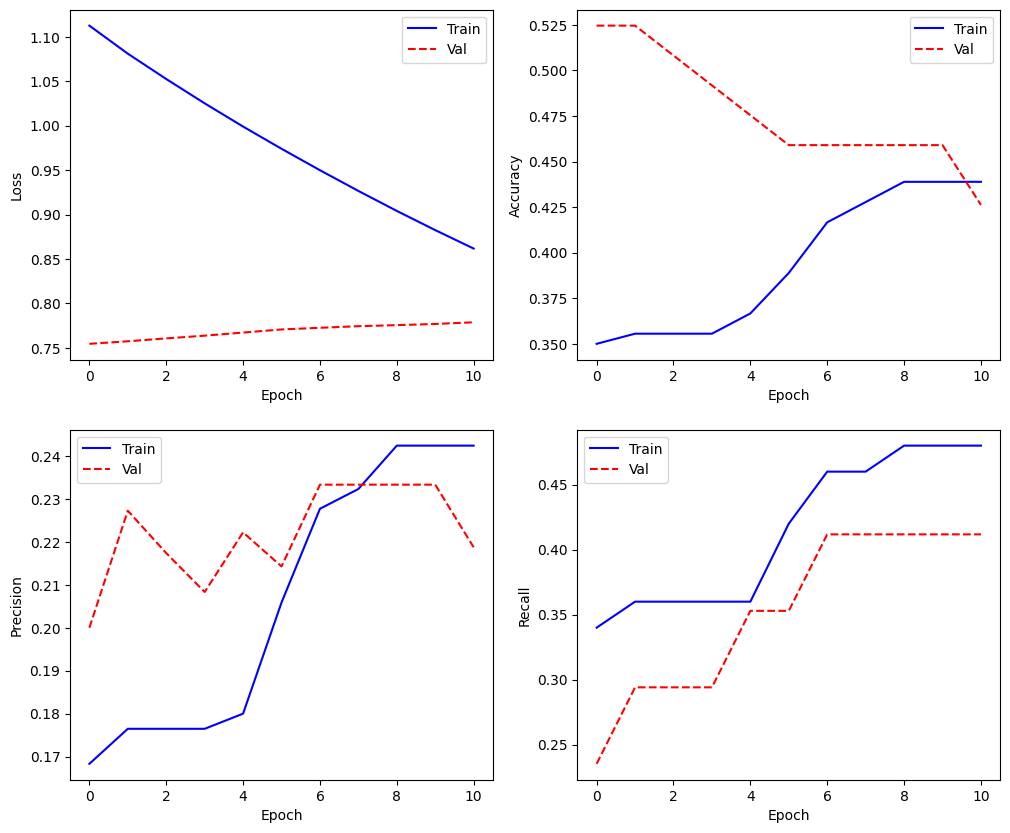

In [165]:
# Plotting learning Curves
plot_metrics(history10)

### Experiment 2 -  3-layer NN with Dropout:  
- __3-Dense Hidden Layer, 32 units, `relu` activation function__
- __Add dropout layers with rate = 0.2__
- 1-Dense Output Layer, 1 unit, `sigmoid` activation function
- __learning rate: 0.0001__
- __optimizer is Adam__
- metrics: 'accuracy', [precision](https://www.tensorflow.org/api_docs/python/tf/keras/metrics/Precision), [recall](https://www.tensorflow.org/api_docs/python/tf/keras/metrics/Recall)
- loss: [binary crossentropy](https://www.tensorflow.org/api_docs/python/tf/keras/losses/BinaryCrossentropy)
- __epochs: 10000__
- __Use the [early stopping](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping) callback to stop training as soon as the validation loss doesn't decrease after 10 epochs i.e. `patience=10` and `monitor='val_loss'`__
- __Modify `class_weight` in `model.fit()`__
- batch size: 32
- use training data and validation data in `fit()` function
- use `predict()` on test data and show confusion matrix and classification reports

In [166]:
# Define model
model11 = tf.keras.models.Sequential(
    [
        tf.keras.layers.Flatten(input_shape=X_train.shape[1:]),
        tf.keras.layers.Dropout(rate=0.2),
        tf.keras.layers.Dense(32, activation="relu", kernel_initializer="he_normal"),
        tf.keras.layers.Dropout(rate=0.2),
        tf.keras.layers.Dense(32, activation="relu", kernel_initializer="he_normal"),
        tf.keras.layers.Dropout(rate=0.2),
        tf.keras.layers.Dense(32, activation="relu", kernel_initializer="he_normal"),
        tf.keras.layers.Dropout(rate=0.2),
        tf.keras.layers.Dense(1, activation="sigmoid")
    ]
)


# Compile model
adam_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

model11.compile(
    loss='binary_crossentropy',
    optimizer=adam_optimizer,
    metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)

# Early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,         # Stop training if the validation loss doesn't improve after 10 epochs
    restore_best_weights=True  # Restore the weights from the epoch with the best validation loss
)

# Train model
history11 = model11.fit(
    X_train,
    y_train,
    batch_size=32,
    epochs=10000,
    validation_data=(X_valid, y_valid),
    class_weight=class_weight,
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/10000


/opt/conda/lib/python3.10/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.5344 - loss: 0.7387 - precision_18: 0.2312 - recall_18: 0.3251 - val_accuracy: 0.6557 - val_loss: 0.6353 - val_precision_18: 0.3571 - val_recall_18: 0.2941
Epoch 2/10000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5880 - loss: 0.6911 - precision_18: 0.2905 - recall_18: 0.4068 - val_accuracy: 0.6721 - val_loss: 0.6330 - val_precision_18: 0.3846 - val_recall_18: 0.2941
Epoch 3/10000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6114 - loss: 0.6976 - precision_18: 0.3347 - recall_18: 0.4790 - val_accuracy: 0.6721 - val_loss: 0.6311 - val_precision_18: 0.3846 - val_recall_18: 0.2941
Epoch 4/10000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6071 - loss: 0.6968 - precision_18: 0.3501 - recall_18: 0.5883 - val_accuracy: 0.6557 - val_loss: 0.6295 - val_precision_18: 0.3571 - val_recall_18: 0.2941
Epoch 5/10000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5916 - loss: 0.7003 - precision_18: 0.2985 - recall_18: 0.4168 - 

In [167]:
# Predict on the test data
y_pred_prob = model11.predict(X_test)  # Predict probabilities
y_pred = (y_pred_prob > 0.5).astype("int32")  # Convert probabilities to binary predictions (0 or 1)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


In [168]:
# Calculating the f1_score
from sklearn.metrics import confusion_matrix, classification_report, f1_score

f1_dt_bs = round(f1_score(y_test, y_pred, average='weighted') * 100, 2)
print('F1 Score of the model:', f1_dt_bs)
print('-' * 60)
print(classification_report(y_test, y_pred))
f1_dt_bs_class_0 = round(classification_report(y_test, y_pred, output_dict=True)['0']['f1-score'],2)
f1_dt_bs_class_1 = round(classification_report(y_test, y_pred, output_dict=True)['1']['f1-score'],2)
print('-' * 60)
pd.DataFrame(confusion_matrix(y_test, y_pred),
             columns=['No', 'Yes'], index=['No', 'Yes'])

F1 Score of the model: 93.45
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.98      0.93      0.95        44
           1       0.83      0.94      0.88        16

    accuracy                           0.93        60
   macro avg       0.90      0.93      0.92        60
weighted avg       0.94      0.93      0.93        60

------------------------------------------------------------


,No,Yes
No,41,3
Yes,1,15


In [169]:
# Validation on the test data set
test_result11 = model11.evaluate(X_test, y_test, verbose=0)         # verbose=0：不会显示任何输出。评估过程将默默运行。


# Print the results
print("Test Loss: {:.4f}".format(test_result11[0]))       # Loss (binary crossentropy)
print("Test Accuracy: {:.4f}".format(test_result11[1]))   # Accuracy
print("Test Precision: {:.4f}".format(test_result11[2]))  # Precision
print("Test Recall: {:.4f}".format(test_result11[3]))     # Recall

Test Loss: 0.2975
Test Accuracy: 0.9333
Test Precision: 0.8333
Test Recall: 0.9375


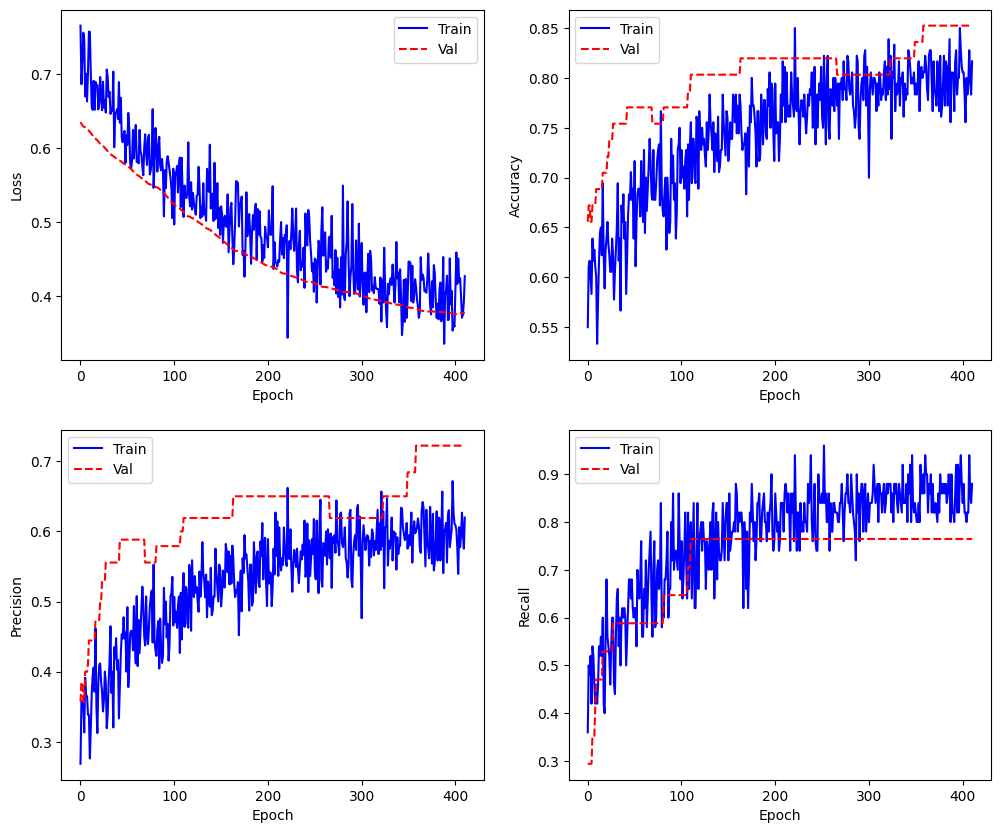

In [170]:
# Plotting learning Curves
plot_metrics(history11)

### Experiment 3 -  3-layer NN with L2 Layer regularizer:  
- __3-Dense Hidden Layer, 32 units, `relu` activation function and kernel_regularizer should be `tf.keras.regularizers.l2(0.001)`__
- 1-Dense Output Layer, 1 unit, `sigmoid` activation function
- __learning rate: 0.0001__
- __optimizer is Adam__
- metrics: 'accuracy', [precision](https://www.tensorflow.org/api_docs/python/tf/keras/metrics/Precision), [recall](https://www.tensorflow.org/api_docs/python/tf/keras/metrics/Recall)
- loss: [binary crossentropy](https://www.tensorflow.org/api_docs/python/tf/keras/losses/BinaryCrossentropy)
- __epochs: 10000__
- __Use the [early stopping](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping) callback to stop training as soon as the validation loss doesn't decrease after 10 epochs i.e. `patience=10` and `monitor='val_loss'`__
- __Modify `class_weight` in `model.fit()`__
- batch size: 32
- use training data and validation data in `fit()` function
- use `predict()` on test data and show confusion matrix and classification reports

In [171]:
# Define model
model12 = tf.keras.models.Sequential(
    [
        tf.keras.layers.Flatten(input_shape=X_train.shape[1:]),

        # 1st Dense Layer with L2 Regularization
        tf.keras.layers.Dense(
            32, activation="relu",
            kernel_initializer="he_normal",
            kernel_regularizer=tf.keras.regularizers.l2(0.001)
        ),


        # 2nd Dense Layer with L2 Regularization
        tf.keras.layers.Dense(
            32, activation="relu",
            kernel_initializer="he_normal",
            kernel_regularizer=tf.keras.regularizers.l2(0.001)
        ),


        # 3rd Dense Layer with L2 Regularization
        tf.keras.layers.Dense(
            32, activation="relu",
            kernel_initializer="he_normal",
            kernel_regularizer=tf.keras.regularizers.l2(0.001)
        ),

        tf.keras.layers.Dense(1, activation="sigmoid")
    ]
)


# Compile model
adam_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

model12.compile(
    loss='binary_crossentropy',
    optimizer=adam_optimizer,
    metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)

# Early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,         # Stop training if the validation loss doesn't improve after 10 epochs
    restore_best_weights=True  # Restore the weights from the epoch with the best validation loss
)

# Train model
history12 = model12.fit(
    X_train,
    y_train,
    batch_size=32,
    epochs=10000,
    validation_data=(X_valid, y_valid),
    class_weight=class_weight,
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/10000


/opt/conda/lib/python3.10/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 337ms/step - accuracy: 0.6767 - loss: 1.0140 - precision_19: 0.0752 - recall_19: 0.0220 - val_accuracy: 0.6557 - val_loss: 0.8582 - val_precision_19: 0.1667 - val_recall_19: 0.0588
Epoch 2/10000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6791 - loss: 1.0008 - precision_19: 0.0789 - recall_19: 0.0220 - val_accuracy: 0.6721 - val_loss: 0.8529 - val_precision_19: 0.2000 - val_recall_19: 0.0588
Epoch 3/10000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6816 - loss: 0.9886 - precision_19: 0.0832 - recall_19: 0.0220 - val_accuracy: 0.6721 - val_loss: 0.8478 - val_precision_19: 0.2000 - val_recall_19: 0.0588
Epoch 4/10000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6852 - loss: 0.9768 - precision_19: 0.1235 - recall_19: 0.0350 - val_accuracy: 0.6721 - val_loss: 0.8427 - val_precision_19: 0.2000 - val_recall_19: 0.0588
Epoch 5/10000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6852 - loss: 0.9654 - precision_19: 0.1235 - recall_19: 0.03

In [172]:
# Predict on the test data
y_pred_prob = model11.predict(X_test)  # Predict probabilities
y_pred = (y_pred_prob > 0.5).astype("int32")  # Convert probabilities to binary predictions (0 or 1)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


In [173]:
# Calculating the f1_score
from sklearn.metrics import confusion_matrix, classification_report, f1_score

f1_dt_bs = round(f1_score(y_test, y_pred, average='weighted') * 100, 2)
print('F1 Score of the model:', f1_dt_bs)
print('-' * 60)
print(classification_report(y_test, y_pred))
f1_dt_bs_class_0 = round(classification_report(y_test, y_pred, output_dict=True)['0']['f1-score'],2)
f1_dt_bs_class_1 = round(classification_report(y_test, y_pred, output_dict=True)['1']['f1-score'],2)
print('-' * 60)
pd.DataFrame(confusion_matrix(y_test, y_pred),
             columns=['No', 'Yes'], index=['No', 'Yes'])

F1 Score of the model: 93.45
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.98      0.93      0.95        44
           1       0.83      0.94      0.88        16

    accuracy                           0.93        60
   macro avg       0.90      0.93      0.92        60
weighted avg       0.94      0.93      0.93        60

------------------------------------------------------------


,No,Yes
No,41,3
Yes,1,15


In [174]:
# Validation on the test data set
test_result12 = model11.evaluate(X_test, y_test, verbose=0)         # verbose=0：不会显示任何输出。评估过程将默默运行。


# Print the results
print("Test Loss: {:.4f}".format(test_result12[0]))       # Loss (binary crossentropy)
print("Test Accuracy: {:.4f}".format(test_result12[1]))   # Accuracy
print("Test Precision: {:.4f}".format(test_result12[2]))  # Precision
print("Test Recall: {:.4f}".format(test_result12[3]))     # Recall

Test Loss: 0.2975
Test Accuracy: 0.9333
Test Precision: 0.8333
Test Recall: 0.9375


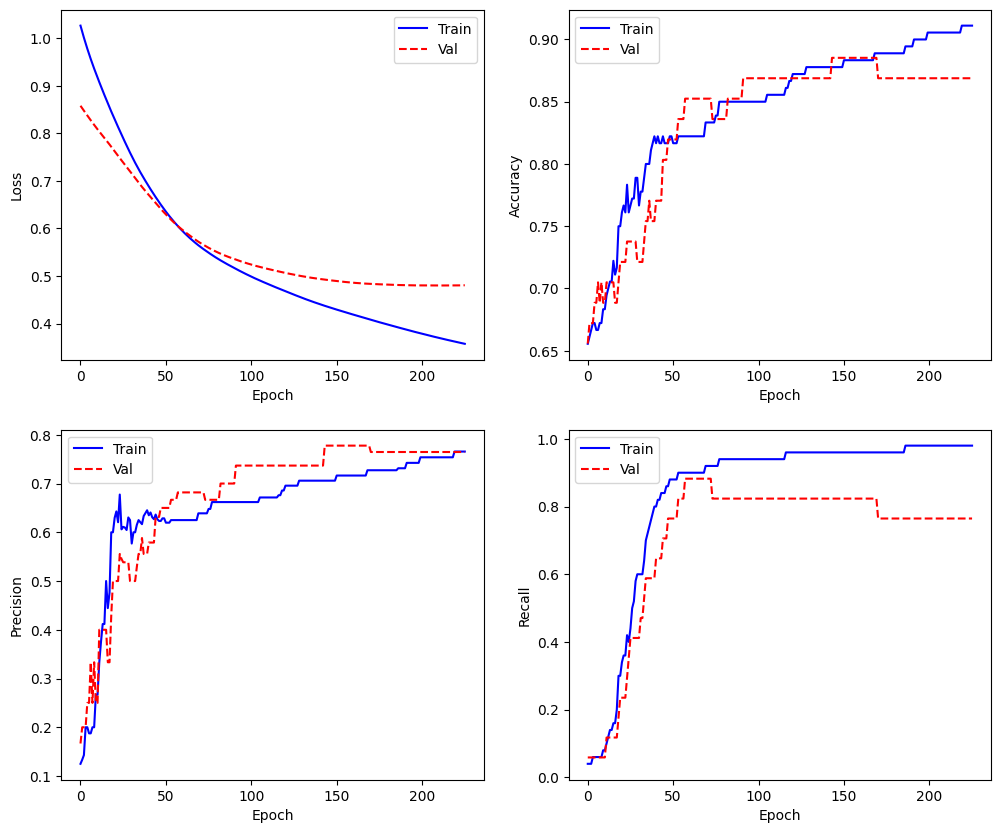

In [175]:
# Plotting learning Curves
plot_metrics(history12)

# Task 8: Learning Rate Scheduling in NNs

_[We know that our dataset is heavily imbalanced between the two classes, feel free to leverage the`class_weight` parameter in the `model.fit()` function and experiment with your own weights or use [compute class weight](https://scikit-learn.org/stable/modules/generated/sklearn.utils.class_weight.compute_class_weight.html) from `sklearn`]_

__Run the following experiments separately to train multi-layer neural networks with different methods of learning rate schedulers__, evaluate the performance by looking at learning curve plots and finally check the performance of each of the following models on the test dataset.

We will try the following methods for LR scheduling:
- Exponential Decay
- Cosine Decay

__Recall: Learning Rate Schedulers help in increasing or decreasing learning rate with change in epochs to help coverge faster during NN training__

Key workflow:

- Build model using architecture specification based on experiment
- Plot learning curves from model training to visualize performance over epochs on training and validation data
- Use trained model to predict and evaluate performance on test data
- Build separate models for each experiment


In [176]:
import numpy as np
import math
import tensorflow.keras.backend as K
import matplotlib.pyplot as plt

class ExponentialLearningRate(tf.keras.callbacks.Callback):
    def __init__(self, factor):
        self.factor = factor
        self.rates = []
        self.losses = []

    def on_epoch_begin(self, epoch, logs=None):
        self.prev_loss = 0

    def on_batch_end(self, batch, logs=None):
        batch_loss = logs["loss"] * (batch + 1) - self.prev_loss * batch
        self.prev_loss = logs["loss"]
        self.rates.append(K.get_value(self.model.optimizer.learning_rate))
        self.losses.append(batch_loss)

        # Update the learning rate using K.set_value
        current_lr = K.get_value(self.model.optimizer.learning_rate)
        K.set_value(self.model.optimizer.learning_rate, current_lr * self.factor)

def find_learning_rate(model, X, y, epochs=1, batch_size=32, min_rate=10**-5, max_rate=10):
    init_weights = model.get_weights()
    iterations = math.ceil(len(X) / batch_size) * epochs
    factor = np.exp(np.log(max_rate / min_rate) / iterations)

    # Save the initial learning rate
    init_lr = K.get_value(model.optimizer.learning_rate)

    # Set the learning rate to the minimum rate
    K.set_value(model.optimizer.learning_rate, min_rate)

    # Create the ExponentialLearningRate callback
    exp_lr = ExponentialLearningRate(factor)

    # Train the model
    model.fit(X, y, epochs=epochs, batch_size=batch_size, callbacks=[exp_lr])

    # Restore the original learning rate and model weights
    K.set_value(model.optimizer.learning_rate, init_lr)
    model.set_weights(init_weights)

    return exp_lr.rates, exp_lr.losses

def plot_lr_vs_loss(rates, losses):
    plt.plot(rates, losses)
    plt.gca().set_xscale('log')
    plt.hlines(min(losses), min(rates), max(rates))
    plt.axis([min(rates), max(rates), min(losses), (losses[0] + min(losses)) / 2])
    plt.xlabel("Learning rate")
    plt.ylabel("Loss")
    plt.show()


### Experiment 1 -  3-layer NN with Exponential Decay LR Scheduler:  
- __3-Dense Hidden Layer, 32 units, `relu` activation function__
- 1-Dense Output Layer, 1 unit, `sigmoid` activation function
- __initial learning rate: 0.001__
- __Use [ExponentialDecay](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/schedules/ExponentialDecay) to build your own LR scheduler. Refer to [documentation](https://keras.io/api/optimizers/learning_rate_schedules/exponential_decay/) for an example__
- __Use following config for the LR scheduler: `decay_steps=100,
    decay_rate=0.5, staircase=True` but feel free to experiment also__
- __optimizer is Adam__
- metrics: 'accuracy', [precision](https://www.tensorflow.org/api_docs/python/tf/keras/metrics/Precision), [recall](https://www.tensorflow.org/api_docs/python/tf/keras/metrics/Recall)
- loss: [binary crossentropy](https://www.tensorflow.org/api_docs/python/tf/keras/losses/BinaryCrossentropy)
- __epochs: 10000__
- __Use the [early stopping](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping) callback to stop training as soon as the validation loss doesn't decrease after 10 epochs i.e. `patience=10` and `monitor='val_loss'`__
- __Modify `class_weight` in `model.fit()`__
- batch size: 32
- use training data and validation data in `fit()` function
- use `predict()` on test data and show confusion matrix and classification reports

In [178]:
# Define model
model13 = tf.keras.models.Sequential(
    [
        tf.keras.layers.Flatten(input_shape=X_train.shape[1:]),
        tf.keras.layers.Dense(32, activation="relu"),
        tf.keras.layers.Dense(32, activation="relu"),
        tf.keras.layers.Dense(32, activation="relu"),
        tf.keras.layers.Dense(1, activation="sigmoid")
    ]
)
{0: 0.6923076923076923, 1: 1.8}

# Learning Rate + ExponentialDecay
initial_learning_rate = 0.001
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=100,
    decay_rate=0.5,
    staircase=True)

adam_optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)


# Compile model
model13.compile(
    loss='binary_crossentropy',
    optimizer=adam_optimizer,
    metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)

# Early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,         # Stop training if the validation loss doesn't improve after 10 epochs
    restore_best_weights=True  # Restore the weights from the epoch with the best validation loss
)

# Train model
history13 = model13.fit(
    X_train,
    y_train,
    batch_size=32,
    epochs=10000,
    validation_data=(X_valid, y_valid),
    class_weight = class_weight,
    callbacks=[early_stopping],
    verbose=1
)


Epoch 1/10000


/opt/conda/lib/python3.10/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 250ms/step - accuracy: 0.3161 - loss: 0.6845 - precision_20: 0.2717 - recall_20: 0.9595 - val_accuracy: 0.4098 - val_loss: 0.7048 - val_precision_20: 0.3208 - val_recall_20: 1.0000
Epoch 2/10000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4426 - loss: 0.6416 - precision_20: 0.3190 - recall_20: 0.9910 - val_accuracy: 0.4918 - val_loss: 0.6790 - val_precision_20: 0.3542 - val_recall_20: 1.0000
Epoch 3/10000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5708 - loss: 0.6112 - precision_20: 0.3806 - recall_20: 0.9910 - val_accuracy: 0.6230 - val_loss: 0.6583 - val_precision_20: 0.4167 - val_recall_20: 0.8824
Epoch 4/10000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6764 - loss: 0.5836 - precision_20: 0.4469 - recall_20: 0.9819 - val_accuracy: 0.7213 - val_loss: 0.6364 - val_precision_20: 0.5000 - val_recall_20: 0.8824
Epoch 5/10000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7197 - loss: 0.5562 - precision_20: 0.4842 - recall_20: 0.9819 

In [180]:
# Predict on the test data
y_pred_prob = model11.predict(X_test)  # Predict probabilities
y_pred = (y_pred_prob > 0.5).astype("int32")  # Convert probabilities to binary predictions (0 or 1)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


In [181]:
# Calculating the f1_score
from sklearn.metrics import confusion_matrix, classification_report, f1_score

f1_dt_bs = round(f1_score(y_test, y_pred, average='weighted') * 100, 2)
print('F1 Score of the model:', f1_dt_bs)
print('-' * 60)
print(classification_report(y_test, y_pred))
f1_dt_bs_class_0 = round(classification_report(y_test, y_pred, output_dict=True)['0']['f1-score'],2)
f1_dt_bs_class_1 = round(classification_report(y_test, y_pred, output_dict=True)['1']['f1-score'],2)
print('-' * 60)
pd.DataFrame(confusion_matrix(y_test, y_pred),
             columns=['No', 'Yes'], index=['No', 'Yes'])

F1 Score of the model: 93.45
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.98      0.93      0.95        44
           1       0.83      0.94      0.88        16

    accuracy                           0.93        60
   macro avg       0.90      0.93      0.92        60
weighted avg       0.94      0.93      0.93        60

------------------------------------------------------------


,No,Yes
No,41,3
Yes,1,15


In [182]:
# Validation on the test data set
test_result13 = model11.evaluate(X_test, y_test, verbose=0)         # verbose=0：不会显示任何输出。评估过程将默默运行。


# Print the results
print("Test Loss: {:.4f}".format(test_result13[0]))       # Loss (binary crossentropy)
print("Test Accuracy: {:.4f}".format(test_result13[1]))   # Accuracy
print("Test Precision: {:.4f}".format(test_result13[2]))  # Precision
print("Test Recall: {:.4f}".format(test_result13[3]))     # Recall

Test Loss: 0.2975
Test Accuracy: 0.9333
Test Precision: 0.8333
Test Recall: 0.9375


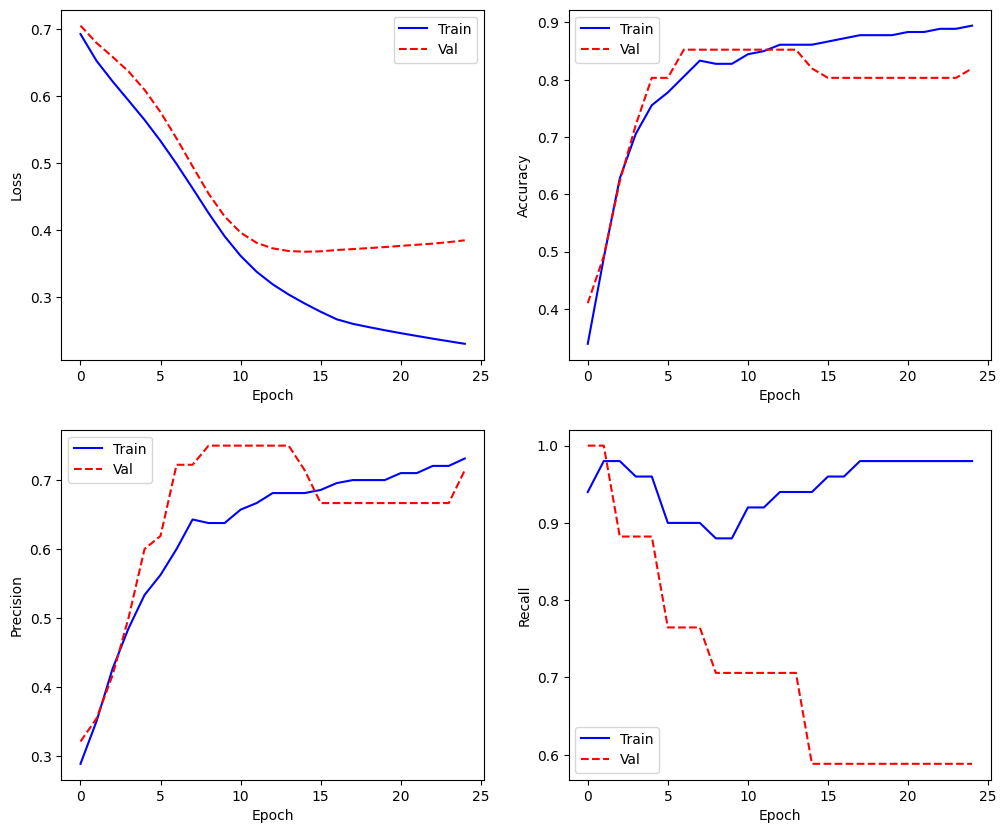

In [183]:
# Plotting learning Curves
plot_metrics(history13)

### Experiment 2 -  3-layer NN with Cosine Decay LR Scheduler:  
- __3-Dense Hidden Layer, 32 units, `relu` activation function__
- 1-Dense Output Layer, 1 unit, `sigmoid` activation function
- __initial learning rate: 0.001__
- __Use [CosineDecay](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/schedules/CosineDecay) to build your own LR scheduler. Refer to [documentation](https://keras.io/api/optimizers/learning_rate_schedules/exponential_decay/) for an example__
- __Use following config for the LR scheduler: `decay_steps=100 but feel free to experiment also__
- __optimizer is Adam__
- metrics: 'accuracy', [precision](https://www.tensorflow.org/api_docs/python/tf/keras/metrics/Precision), [recall](https://www.tensorflow.org/api_docs/python/tf/keras/metrics/Recall)
- loss: [binary crossentropy](https://www.tensorflow.org/api_docs/python/tf/keras/losses/BinaryCrossentropy)
- __epochs: 10000__
- __Use the [early stopping](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping) callback to stop training as soon as the validation loss doesn't decrease after 10 epochs i.e. `patience=10` and `monitor='val_loss'`__
- __Modify `class_weight` in `model.fit()`__
- batch size: 32
- use training data and validation data in `fit()` function
- use `predict()` on test data and show confusion matrix and classification reports

In [184]:
# Define model
model14 = tf.keras.models.Sequential(
    [
        tf.keras.layers.Flatten(input_shape=X_train.shape[1:]),
        tf.keras.layers.Dense(32, activation="relu"),
        tf.keras.layers.Dense(32, activation="relu"),
        tf.keras.layers.Dense(32, activation="relu"),
        tf.keras.layers.Dense(1, activation="sigmoid")
    ]
)


# Learning Rate + ExponentialDecay
initial_learning_rate = 0.001
lr_schedule = tf.keras.optimizers.schedules.CosineDecay(
    initial_learning_rate,
    decay_steps=100
)

adam_optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)


# Compile model
model14.compile(
    loss='binary_crossentropy',
    optimizer=adam_optimizer,
    metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)

# Early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,         # Stop training if the validation loss doesn't improve after 10 epochs
    restore_best_weights=True  # Restore the weights from the epoch with the best validation loss
)

# Train model
history14 = model14.fit(
    X_train,
    y_train,
    batch_size=32,
    epochs=10000,
    validation_data=(X_valid, y_valid),
    class_weight=class_weight,
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/10000


/opt/conda/lib/python3.10/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 252ms/step - accuracy: 0.4331 - loss: 0.6767 - precision_21: 0.2954 - recall_21: 0.8303 - val_accuracy: 0.5902 - val_loss: 0.6757 - val_precision_21: 0.3889 - val_recall_21: 0.8235
Epoch 2/10000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6318 - loss: 0.6484 - precision_21: 0.4081 - recall_21: 0.8909 - val_accuracy: 0.7213 - val_loss: 0.6553 - val_precision_21: 0.5000 - val_recall_21: 0.7059
Epoch 3/10000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7149 - loss: 0.6227 - precision_21: 0.4758 - recall_21: 0.9178 - val_accuracy: 0.7541 - val_loss: 0.6353 - val_precision_21: 0.5455 - val_recall_21: 0.7059
Epoch 4/10000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7338 - loss: 0.5971 - precision_21: 0.4952 - recall_21: 0.9632 - val_accuracy: 0.7869 - val_loss: 0.6143 - val_precision_21: 0.5909 - val_recall_21: 0.7647
Epoch 5/10000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7644 - loss: 0.5713 - precision_21: 0.5270 - recall_21: 0.9575 

In [185]:
# Predict on the test data
y_pred_prob = model11.predict(X_test)  # Predict probabilities
y_pred = (y_pred_prob > 0.5).astype("int32")  # Convert probabilities to binary predictions (0 or 1)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


In [186]:
# Calculating the f1_score
from sklearn.metrics import confusion_matrix, classification_report, f1_score

f1_dt_bs = round(f1_score(y_test, y_pred, average='weighted') * 100, 2)
print('F1 Score of the model:', f1_dt_bs)
print('-' * 60)
print(classification_report(y_test, y_pred))
f1_dt_bs_class_0 = round(classification_report(y_test, y_pred, output_dict=True)['0']['f1-score'],2)
f1_dt_bs_class_1 = round(classification_report(y_test, y_pred, output_dict=True)['1']['f1-score'],2)
print('-' * 60)
pd.DataFrame(confusion_matrix(y_test, y_pred),
             columns=['No', 'Yes'], index=['No', 'Yes'])

F1 Score of the model: 93.45
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.98      0.93      0.95        44
           1       0.83      0.94      0.88        16

    accuracy                           0.93        60
   macro avg       0.90      0.93      0.92        60
weighted avg       0.94      0.93      0.93        60

------------------------------------------------------------


,No,Yes
No,41,3
Yes,1,15


In [187]:
# Validation on the test data set
test_result14 = model11.evaluate(X_test, y_test, verbose=0)         # verbose=0：不会显示任何输出。评估过程将默默运行。


# Print the results
print("Test Loss: {:.4f}".format(test_result14[0]))       # Loss (binary crossentropy)
print("Test Accuracy: {:.4f}".format(test_result14[1]))   # Accuracy
print("Test Precision: {:.4f}".format(test_result14[2]))  # Precision
print("Test Recall: {:.4f}".format(test_result14[3]))     # Recall

Test Loss: 0.2975
Test Accuracy: 0.9333
Test Precision: 0.8333
Test Recall: 0.9375


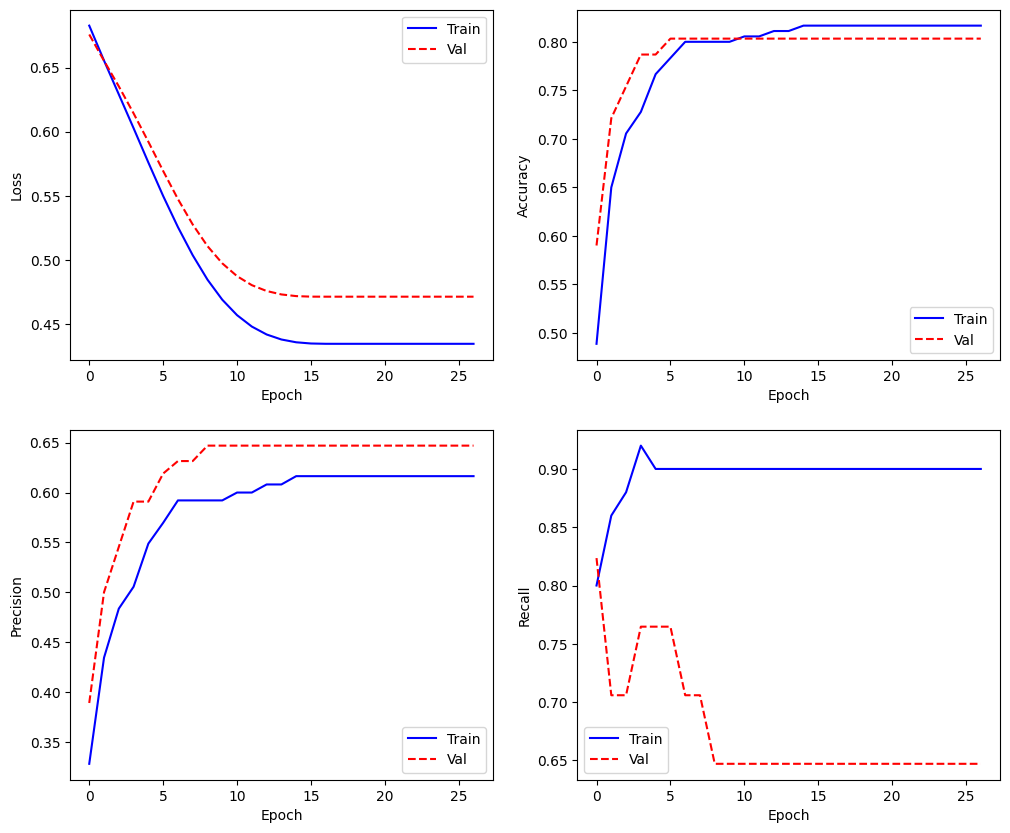

In [188]:
# Plotting learning Curves
plot_metrics(history14)

# Summary

In [197]:
results = [
    {'Model': 'Model 1', 'Loss': test_result1[0], 'Accuracy': test_result1[1], 'Precision': test_result1[2], 'Recall': test_result1[3]},
    {'Model': 'Model 2', 'Loss': test_result2[0], 'Accuracy': test_result2[1], 'Precision': test_result2[2], 'Recall': test_result2[3]},
    {'Model': 'Model 3', 'Loss': test_result3[0], 'Accuracy': test_result3[1], 'Precision': test_result3[2], 'Recall': test_result3[3]},
    {'Model': 'Model 4', 'Loss': test_result4[0], 'Accuracy': test_result4[1], 'Precision': test_result4[2], 'Recall': test_result4[3]},
    {'Model': 'Model 5', 'Loss': test_result5[0], 'Accuracy': test_result5[1], 'Precision': test_result5[2], 'Recall': test_result5[3]},
    {'Model': 'Model 6', 'Loss': test_result6[0], 'Accuracy': test_result6[1], 'Precision': test_result6[2], 'Recall': test_result6[3]},
    {'Model': 'Model 7', 'Loss': test_result7[0], 'Accuracy': test_result7[1], 'Precision': test_result7[2], 'Recall': test_result7[3]},
    {'Model': 'Model 8', 'Loss': test_result8[0], 'Accuracy': test_result8[1], 'Precision': test_result8[2], 'Recall': test_result8[3]},
    {'Model': 'Model 9', 'Loss': test_result9[0], 'Accuracy': test_result9[1], 'Precision': test_result9[2], 'Recall': test_result9[3]},
    {'Model': 'Model 10', 'Loss': test_result10[0], 'Accuracy': test_result10[1], 'Precision': test_result10[2], 'Recall': test_result10[3]},
    {'Model': 'Model 11', 'Loss': test_result11[0], 'Accuracy': test_result11[1], 'Precision': test_result11[2], 'Recall': test_result11[3]},
    {'Model': 'Model 12', 'Loss': test_result12[0], 'Accuracy': test_result12[1], 'Precision': test_result12[2], 'Recall': test_result12[3]},
    {'Model': 'Model 13', 'Loss': test_result13[0], 'Accuracy': test_result13[1], 'Precision': test_result13[2], 'Recall': test_result13[3]},
    {'Model': 'Model 14', 'Loss': test_result14[0], 'Accuracy': test_result14[1], 'Precision': test_result14[2], 'Recall': test_result14[3]}
]

results_df = pd.DataFrame(results)
results_df.sort_values(by="Accuracy", ascending = False).round(2)

,Model,Loss,Accuracy,Precision,Recall
12,Model 13,0.30,0.93,0.83,0.94
13,Model 14,0.30,0.93,0.83,0.94
10,Model 11,0.30,0.93,0.83,0.94
11,Model 12,0.30,0.93,0.83,0.94
5,Model 6,0.29,0.90,0.86,0.75
7,Model 8,0.29,0.88,0.80,0.75
6,Model 7,0.28,0.88,0.76,0.81
8,Model 9,0.29,0.88,0.76,0.81
4,Model 5,0.30,0.87,0.90,0.56
3,Model 4,1.82,0.83,0.71,0.62


# Bonus Task: Hyperparameter Tuning with Keras Tuner

Try tuning layer hidden units and learning rate using Keras Tuner based on what you learnt during the live coding and see if you can come up with a better model.

[Live coding example](https://monolith.propulsion-home.ch/backend/api/momentum/materials/ds-materials/05_DeepLearning/day2/pages/DLG_D2_LC1_Training_NN.html#Hyperparameters)

In [190]:
!pip install -q -U keras-tuner

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


In [191]:
import keras_tuner as kt